<a href="https://colab.research.google.com/github/LaZzyMan/Notebook/blob/master/model_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [12]:
!pip install shap geopandas stellargraph

In [13]:
import shap
import pandas as pd
import os
import pickle
import numpy as np
from tqdm import tqdm
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import datetime
import stellargraph as sg
import xgboost as xgb
import networkx as nx

from xgboost import plot_importance
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.model_selection import train_test_split

In [21]:
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = 'SimHei'
sns.set(style='whitegrid')
sns.set_context('paper')

In [15]:
graph_traffic, graph_spatial, graph_ts = pickle.load(open('/content/drive/My Drive/Data/graphs/sg_graphs_undirected_20151201_land_cover_poi_building_15_1000_ssp.pickle', 'rb'))
labels = pickle.load(open('/content/drive/My Drive/Data/label.pickle', 'rb'))
exclude_node = ['32715', '32955', '37779', '37812', '37831', '38504', '39172', '39675', '39981', '39043']
for node in exclude_node:
  labels.pop(node)
num_nodes = len(labels)
X = []
Y = []
for node, label in labels.items():
    X.append(node)
    Y.append(label)
labels = pd.Series(Y, index=X)
gdf = pickle.load(open('/content/drive/My Drive/Data/land_use_unit_display.pickle', 'rb'))
gdf = gdf.drop([int(node) for node in exclude_node])
gdf = gdf.drop(['land_cover', 'poi'], axis=1)
graphs = [graph_traffic, graph_spatial, graph_ts]
p_labels = pickle.load(open('/content/drive/My Drive/Data/P_label.pickle', 'rb'))
X = []
Y = []
for node, label in p_labels.items():
    X.append(node)
    Y.append(label.strip())
p_labels = pd.Series(Y, index=X)

In [16]:
feature_names = ['rice_paddy', 'other_cropland', 'orchard', 'bare_farmland', 'broadleaf_leaf_on', 'broadleaf_leaf_off', 'needleleaf_leaf_off',
          'mixedleaf_leaf_off', 'natural_grassland', 'grassland_leaf_off', 'shrubland_leaf_on', 'shrubland_leaf_off', 'marshland', 
          'mudlaf', 'water', 'herbaceons tundra', 'impervious_surface','bareland', 'land_cover_mix_index', 'shopping_service', 
          'catering_service', 'domestic_service', 'transportation_facilities_service', 'corporate', 'business_residence', 
          'science_and_education_service', 'access_facilities', 'government_agencies_and_social_organizations', 'financial_insurance_service',
          'accommodation_service', 'healthcare_service', 'vehicle_service', 'sport_and_leisure_service', 'public_utilities', 
          'famous_tourist_sites', 'poi_mix_index', 'building_PLAND', 'building_LSI', 'floor_mean', 'floor_std']
X = {}
X_norm = {}
features = graph_traffic.node_features()
norm_features = features / features.max(axis=0)
nodes = list(graph_traffic.nodes())
for idx, feature_name in enumerate(feature_names):
  X[feature_name] = features[:, idx]
  X_norm[feature_name] = norm_features[:, idx]
X = pd.DataFrame(X, index=nodes)
X_norm = pd.DataFrame(X_norm, index=nodes)
classes = ['C', 'G', 'M', 'P', 'R', 'U']
p_classes = ['PA', 'PC', 'PH', 'PE', 'PS', 'PT']
networks = ['Interaction', 'Spatial', 'Time']

In [17]:
model_integrated_gradients = pickle.load(open('/content/drive/My Drive/Data/export/model_igs_1208.pickle', 'rb'))
y_pred = model_integrated_gradients['y_pred']
context_igs = np.array(model_integrated_gradients['node_igs']).sum(2)
feature_igs = np.array(model_integrated_gradients['node_igs']).sum(0)
node_igs = np.array(model_integrated_gradients['node_igs']).sum(-1)
self_igs = np.array(model_integrated_gradients['node_igs'])[list(range(num_nodes)), :, list(range(num_nodes)), :].transpose(1, 0, 2)
node_mask = np.array(model_integrated_gradients['node_igs'])
feature_igs = feature_igs - self_igs
indirect_link_igs = model_integrated_gradients['indirect_link_igs']
direct_link_igs = model_integrated_gradients['direct_link_igs']

In [59]:
for i in range(1514):
  for j in range(6):
    for p in range(2):
      for q in range(6):
        direct_link_igs[i][j][p][q] = direct_link_igs[i][j][p][q].sum()

In [64]:
indirect_link_igs = np.array(indirect_link_igs)
direct_link_igs = np.array(direct_link_igs)

In [19]:
node_idx = graphs[0].nodes()
X = X.loc[list(node_idx)]
c_pred = y_pred.argmax(axis=-1)
c_idx = [np.where(c_pred==i)[0] for i in range(6)]
c_true = [list(labels[labels==c].index) for c in classes]
c_true_idx = [np.array([list(node_idx).index(c) for c in c_true[i]]) for i in range(6)]
p_true = [list(p_labels[p_labels==c].index) for c in p_classes]
p_true_idx = [np.array([list(node_idx).index(c) for c in p_true[i]]) for i in range(6)]

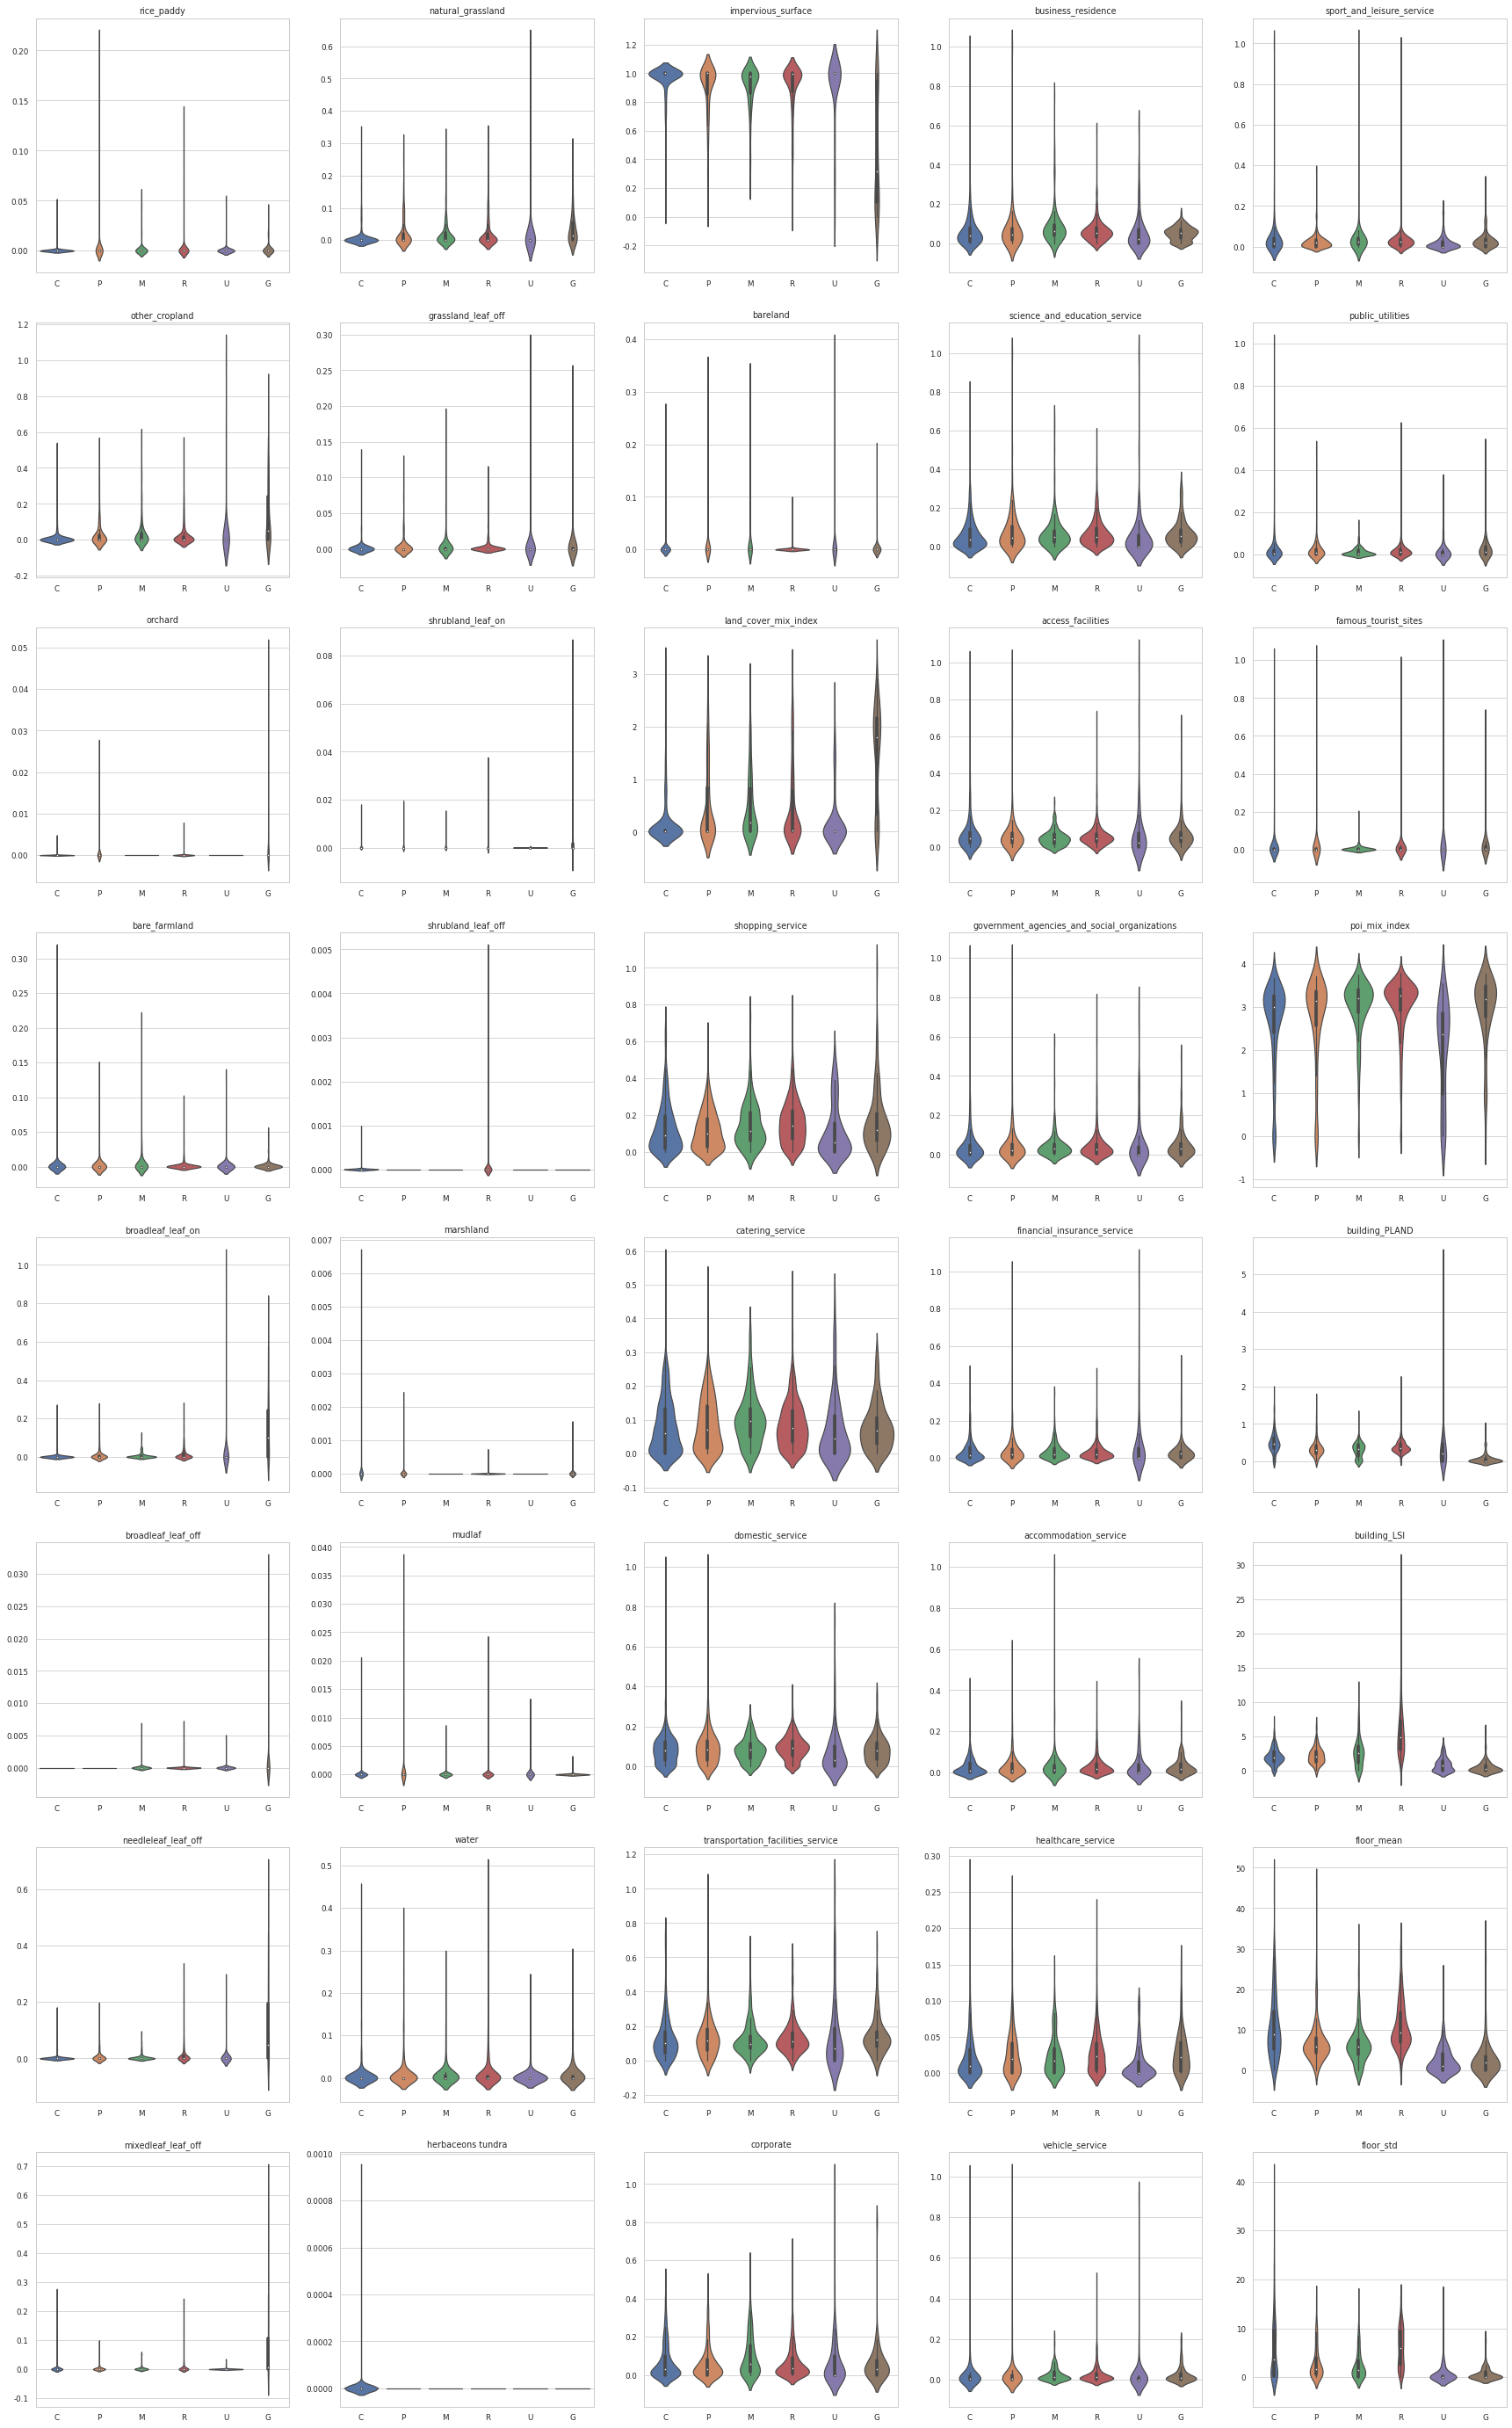

In [22]:
fig, ax = plt.subplots(8, 5, figsize=(30,50))
for i, name in enumerate(feature_names):
  display_feature = {'Feature_Value': [], 'Land_Use': []}
  display_feature['Feature_Value'] += list(X[name])
  display_feature['Land_Use'] += list(labels.loc[list(node_idx)])
  sns.violinplot(data=display_feature, y='Feature_Value', x='Land_Use', ax=ax[i % 8][i // 8])
  ax[i % 8][i // 8].set_title(name)

# Overall

In [113]:
node_mask.shape, direct_link_igs.shape, indirect_link_igs.shape

((1514, 6, 1514, 40), (1514, 6, 2, 6), (1514, 6, 36, 2))

In [241]:
m = graph_traffic.to_adjacency_matrix(weighted=graph_traffic.edge_types[0]).A
X['Mobility_Local_C'] = [m[i][c_true_idx[0]].sum() for i in range(1514)]
X['Mobility_Local_G'] = [m[i][c_true_idx[1]].sum() for i in range(1514)]
X['Mobility_Local_M'] = [m[i][c_true_idx[2]].sum() for i in range(1514)]
X['Mobility_Local_P'] = [m[i][c_true_idx[3]].sum() for i in range(1514)]
X['Mobility_Local_R'] = [m[i][c_true_idx[4]].sum() for i in range(1514)]
X['Mobility_Local_U'] = [m[i][c_true_idx[5]].sum() for i in range(1514)]

m = graph_ts.to_adjacency_matrix(weighted=graph_ts.edge_types[0]).A
X['Rhythm_Local_C'] = [m[i][c_true_idx[0]].sum() for i in range(1514)]
X['Rhythm_Local_G'] = [m[i][c_true_idx[1]].sum() for i in range(1514)]
X['Rhythm_Local_M'] = [m[i][c_true_idx[2]].sum() for i in range(1514)]
X['Rhythm_Local_P'] = [m[i][c_true_idx[3]].sum() for i in range(1514)]
X['Rhythm_Local_R'] = [m[i][c_true_idx[4]].sum() for i in range(1514)]
X['Rhythm_Local_U'] = [m[i][c_true_idx[5]].sum() for i in range(1514)]

X['Mobility_Local_C'] = X['Mobility_Local_C'] / X['Mobility_Local_C'].max()
X['Mobility_Local_G'] = X['Mobility_Local_G'] / X['Mobility_Local_G'].max()
X['Mobility_Local_M'] = X['Mobility_Local_M'] / X['Mobility_Local_M'].max()
X['Mobility_Local_P'] = X['Mobility_Local_P'] / X['Mobility_Local_P'].max()
X['Mobility_Local_R'] = X['Mobility_Local_R'] / X['Mobility_Local_R'].max()
X['Mobility_Local_U'] = X['Mobility_Local_U'] / X['Mobility_Local_U'].max()
X['Rhythm_Local_C'] = X['Rhythm_Local_C'] / X['Rhythm_Local_C'].max()
X['Rhythm_Local_G'] = X['Rhythm_Local_G'] / X['Rhythm_Local_G'].max()
X['Rhythm_Local_M'] = X['Rhythm_Local_M'] / X['Rhythm_Local_M'].max()
X['Rhythm_Local_P'] = X['Rhythm_Local_P'] / X['Rhythm_Local_P'].max()
X['Rhythm_Local_R'] = X['Rhythm_Local_R'] / X['Rhythm_Local_R'].max()
X['Rhythm_Local_U'] = X['Rhythm_Local_U'] / X['Rhythm_Local_U'].max()

In [258]:
X_net = X[['Mobility_Local_C', 'Mobility_Local_G', 'Mobility_Local_M', 'Mobility_Local_P', 'Mobility_Local_R', 'Mobility_Local_U', 'Rhythm_Local_C', 'Rhythm_Local_G', 'Rhythm_Local_M', 'Rhythm_Local_P', 'Rhythm_Local_R', 'Rhythm_Local_U']]

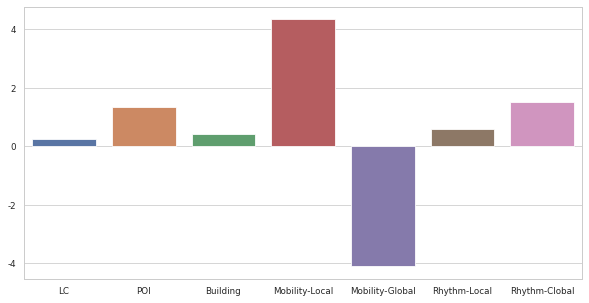

In [126]:
nid = 0
c = 5
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(10,5))
sns.barplot(
    x=['LC', 'POI', 'Building', 'Mobility-Local', 'Mobility-Global', 'Rhythm-Local', 'Rhythm-Clobal'], 
    y=[node_mask.sum(2)[nid][c][:19].sum(), node_mask.sum(2)[nid][c][19:36].sum(), node_mask.sum(2)[nid][c][36:].sum(), direct_link_igs[nid][c][0].sum(), direct_link_igs[nid][c][1].sum(), indirect_link_igs[nid][c].sum(0)[0], indirect_link_igs[nid][c].sum(0)[1]], 
    ax=ax)

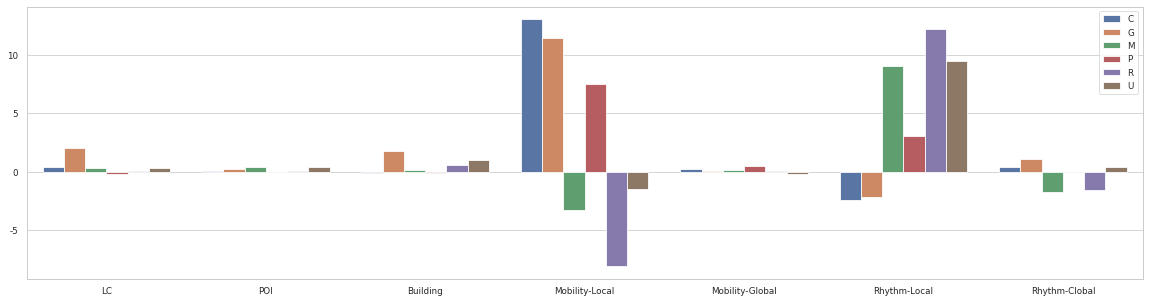

In [171]:
f, ax = plt.subplots(figsize=(20,5))
display = {'Feature': [], 'IG': [], 'Class': []}
for c in range(6):
  display['Feature'] += ['LC', 'POI', 'Building', 'Mobility-Local', 'Mobility-Global', 'Rhythm-Local', 'Rhythm-Clobal']
  display['IG'] += [node_mask[c_true_idx[c]].sum(2).mean(0)[c][:19].sum(), node_mask[c_true_idx[c]].sum(2).mean(0)[c][19:36].sum(), node_mask[c_true_idx[c]].sum(2).mean(0)[c][36:].sum(), direct_link_igs[c_true_idx[c]].mean(0)[c][0].sum(), direct_link_igs[c_true_idx[c]].mean(0)[c][1].sum(), indirect_link_igs[c_true_idx[c]].mean(0)[c].sum(0)[0], indirect_link_igs[c_true_idx[c]].mean(0)[c].sum(0)[1]]
  display['Class'] += [classes[c]] * 7
sns.barplot(data=display, x='Feature', y='IG', hue='Class', ax=ax)

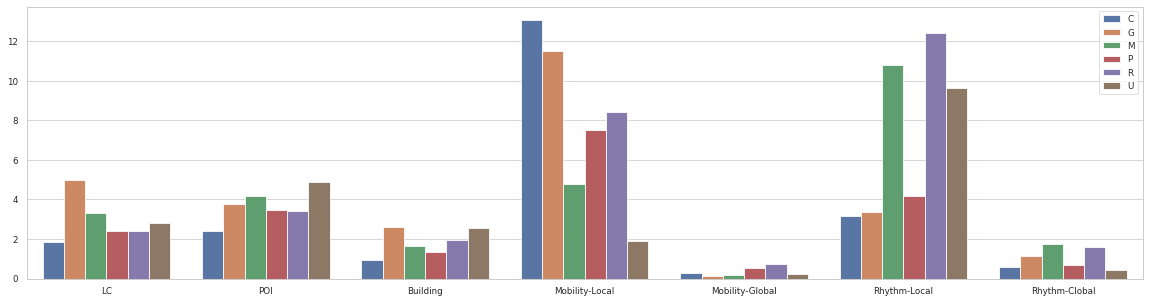

In [172]:
f, ax = plt.subplots(figsize=(20,5))
display = {'Feature': [], 'IG': [], 'Class': []}
for c in range(6):
  display['Feature'] += ['LC', 'POI', 'Building', 'Mobility-Local', 'Mobility-Global', 'Rhythm-Local', 'Rhythm-Clobal']
  display['IG'] += [abs(node_mask)[c_true_idx[c]].sum(2).mean(0)[c][:19].sum(), abs(node_mask)[c_true_idx[c]].sum(2).mean(0)[c][19:36].sum(), abs(node_mask)[c_true_idx[c]].sum(2).mean(0)[c][36:].sum(), abs(direct_link_igs)[c_true_idx[c]].mean(0)[c][0].sum(), abs(direct_link_igs)[c_true_idx[c]].mean(0)[c][1].sum(), abs(indirect_link_igs)[c_true_idx[c]].mean(0)[c].sum(0)[0], abs(indirect_link_igs)[c_true_idx[c]].mean(0)[c].sum(0)[1]]
  display['Class'] += [classes[c]] * 7
sns.barplot(data=display, x='Feature', y='IG', hue='Class', ax=ax)

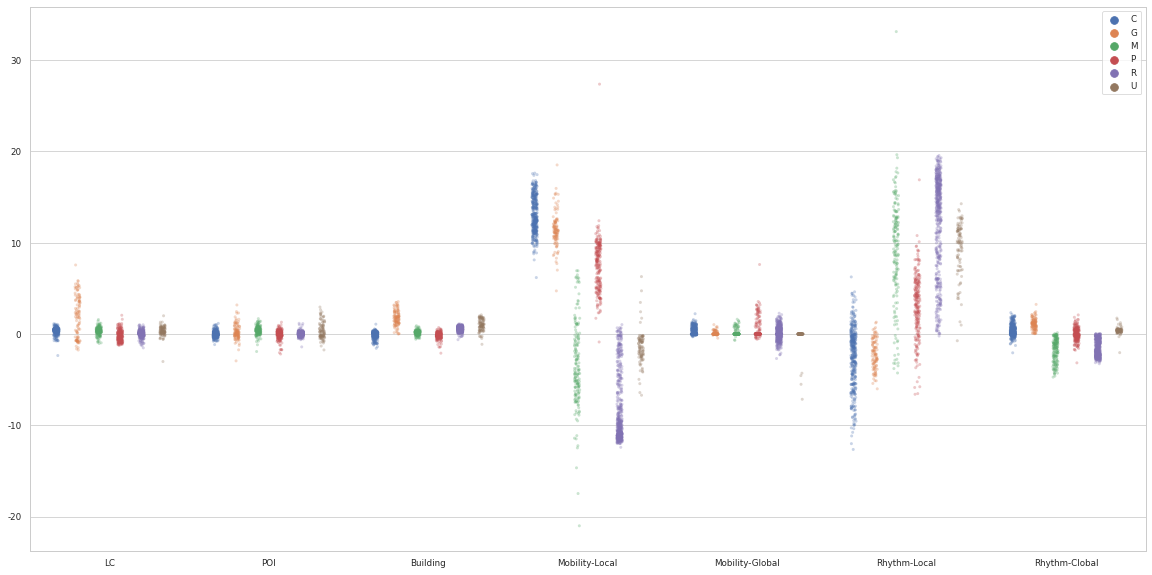

In [202]:
f, ax = plt.subplots(figsize=(20,10))
display = {'Feature': [], 'IG': [], 'Class': []}
for c in range(6):
  display['Feature'] += [i for i in ['LC', 'POI', 'Building', 'Mobility-Local', 'Mobility-Global', 'Rhythm-Local', 'Rhythm-Clobal'] for _ in range(len(c_true_idx[c]))]
  display['IG'] += list(node_mask[c_true_idx[c]].sum(2)[:, c][:, :19].sum(1))
  display['IG'] += list(node_mask[c_true_idx[c]].sum(2)[:, c][:, 19:36].sum(1))
  display['IG'] += list(node_mask[c_true_idx[c]].sum(2)[:, c][:, 36:].sum(1))
  display['IG'] += list(direct_link_igs[c_true_idx[c]][:, c, 0].sum(1))
  display['IG'] += list(direct_link_igs[c_true_idx[c]][:, c, 1].sum(1))
  display['IG'] += list(indirect_link_igs[c_true_idx[c]][:, c, :, 0].sum(1))
  display['IG'] += list(indirect_link_igs[c_true_idx[c]][:, c, :, 1].sum(1))
  display['Class'] += [classes[c]] * 7 * len(c_true_idx[c])
sns.stripplot(data=display, x='Feature', y='IG', hue='Class', ax=ax, dodge=True, jitter=True, size=3, alpha=.3)

# Feature

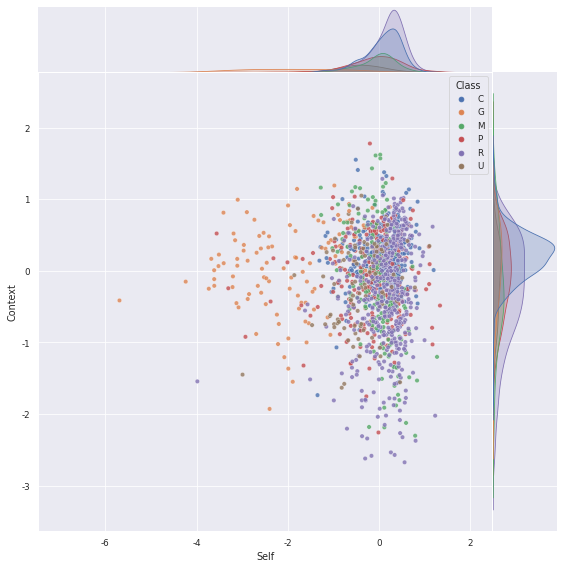

In [91]:
c = 0
self_context = {'Self': [], 'Context': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  self_context['Self'].append(node_igs[i, c, i])
  self_context['Context'].append(node_igs[i, c, :].sum() - node_igs[i, c, i])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Self', y='Context', data=pd.DataFrame(self_context, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

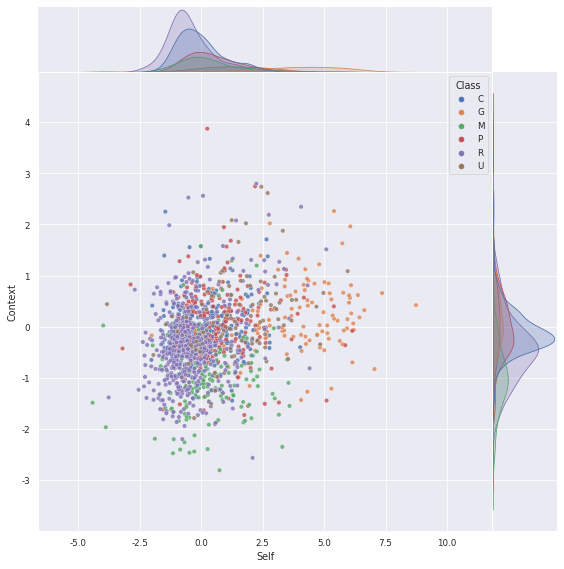

In [92]:
c = 1
self_context = {'Self': [], 'Context': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  self_context['Self'].append(node_igs[i, c, i])
  self_context['Context'].append(node_igs[i, c, :].sum() - node_igs[i, c, i])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Self', y='Context', data=pd.DataFrame(self_context, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

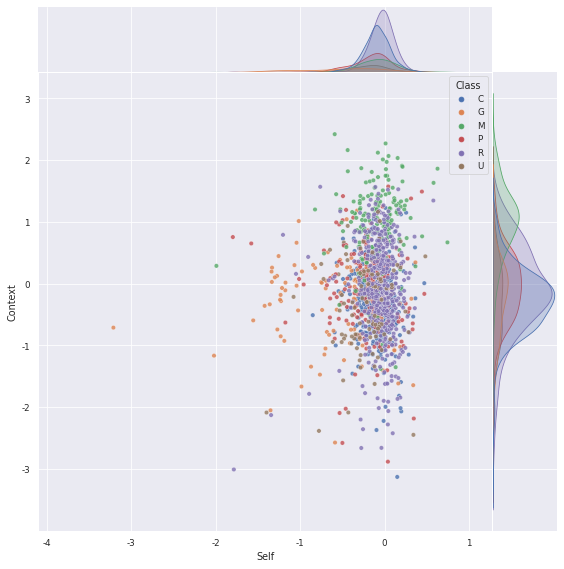

In [93]:
c = 2
self_context = {'Self': [], 'Context': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  self_context['Self'].append(node_igs[i, c, i])
  self_context['Context'].append(node_igs[i, c, :].sum() - node_igs[i, c, i])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Self', y='Context', data=pd.DataFrame(self_context, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

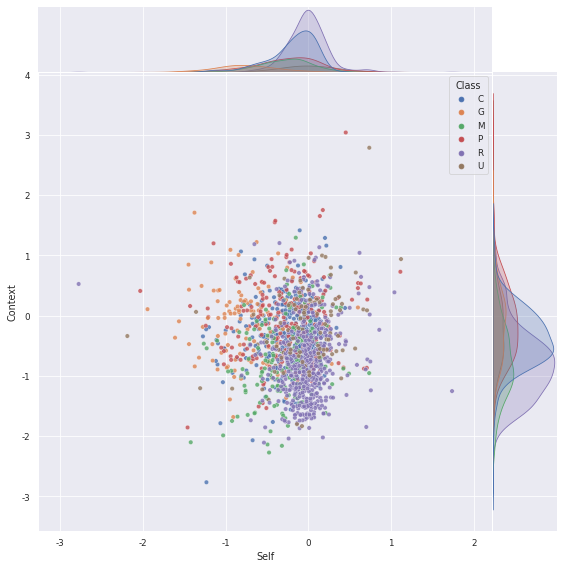

In [94]:
c = 3
self_context = {'Self': [], 'Context': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  self_context['Self'].append(node_igs[i, c, i])
  self_context['Context'].append(node_igs[i, c, :].sum() - node_igs[i, c, i])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Self', y='Context', data=pd.DataFrame(self_context, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

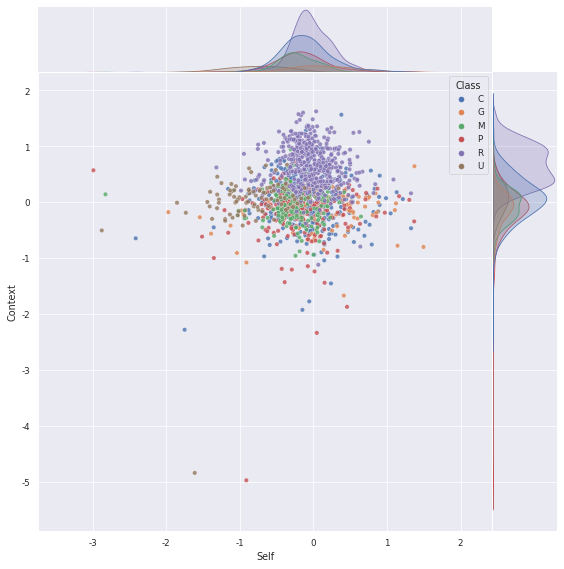

In [95]:
c = 4
self_context = {'Self': [], 'Context': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  self_context['Self'].append(node_igs[i, c, i])
  self_context['Context'].append(node_igs[i, c, :].sum() - node_igs[i, c, i])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Self', y='Context', data=pd.DataFrame(self_context, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

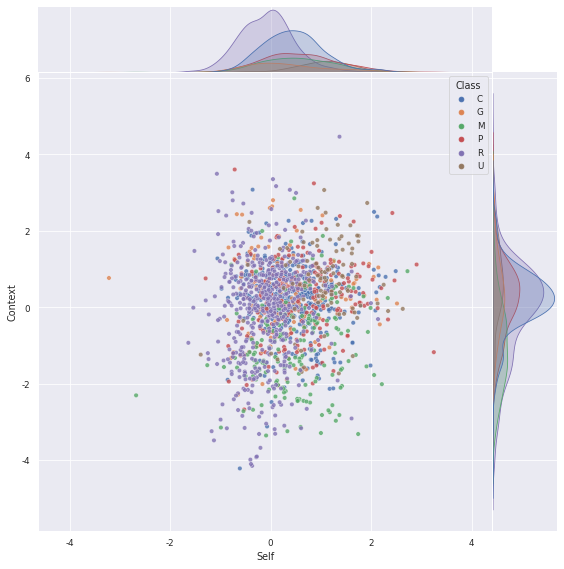

In [96]:
c = 5
self_context = {'Self': [], 'Context': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  self_context['Self'].append(node_igs[i, c, i])
  self_context['Context'].append(node_igs[i, c, :].sum() - node_igs[i, c, i])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Self', y='Context', data=pd.DataFrame(self_context, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7, marginal_kws=dict(common_norm=True))

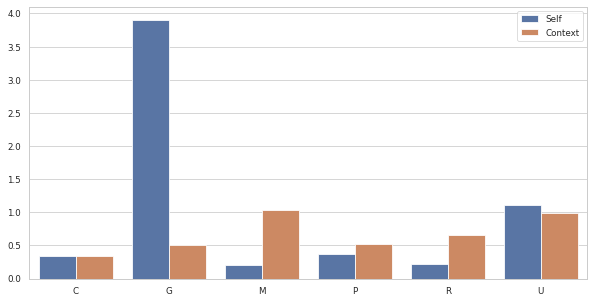

In [97]:
sns.set_style('whitegrid')
self_neighbor_mean = {'IG_Type': [], 'Mean_IG': [], 'Class': []}
for i, c in enumerate(c_true_idx):
  self_neighbor_mean['Mean_IG'].append(abs(node_igs[c, i, c]).mean())
  self_neighbor_mean['Mean_IG'].append(abs(node_igs[c, i, :].sum(-1) - node_igs[c, i, c]).mean())
  self_neighbor_mean['IG_Type'].append('Self')
  self_neighbor_mean['IG_Type'].append('Context')
  self_neighbor_mean['Class'] += [classes[i]] * 2
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=self_neighbor_mean, x='Class', y='Mean_IG', hue='IG_Type')

# Feature Self

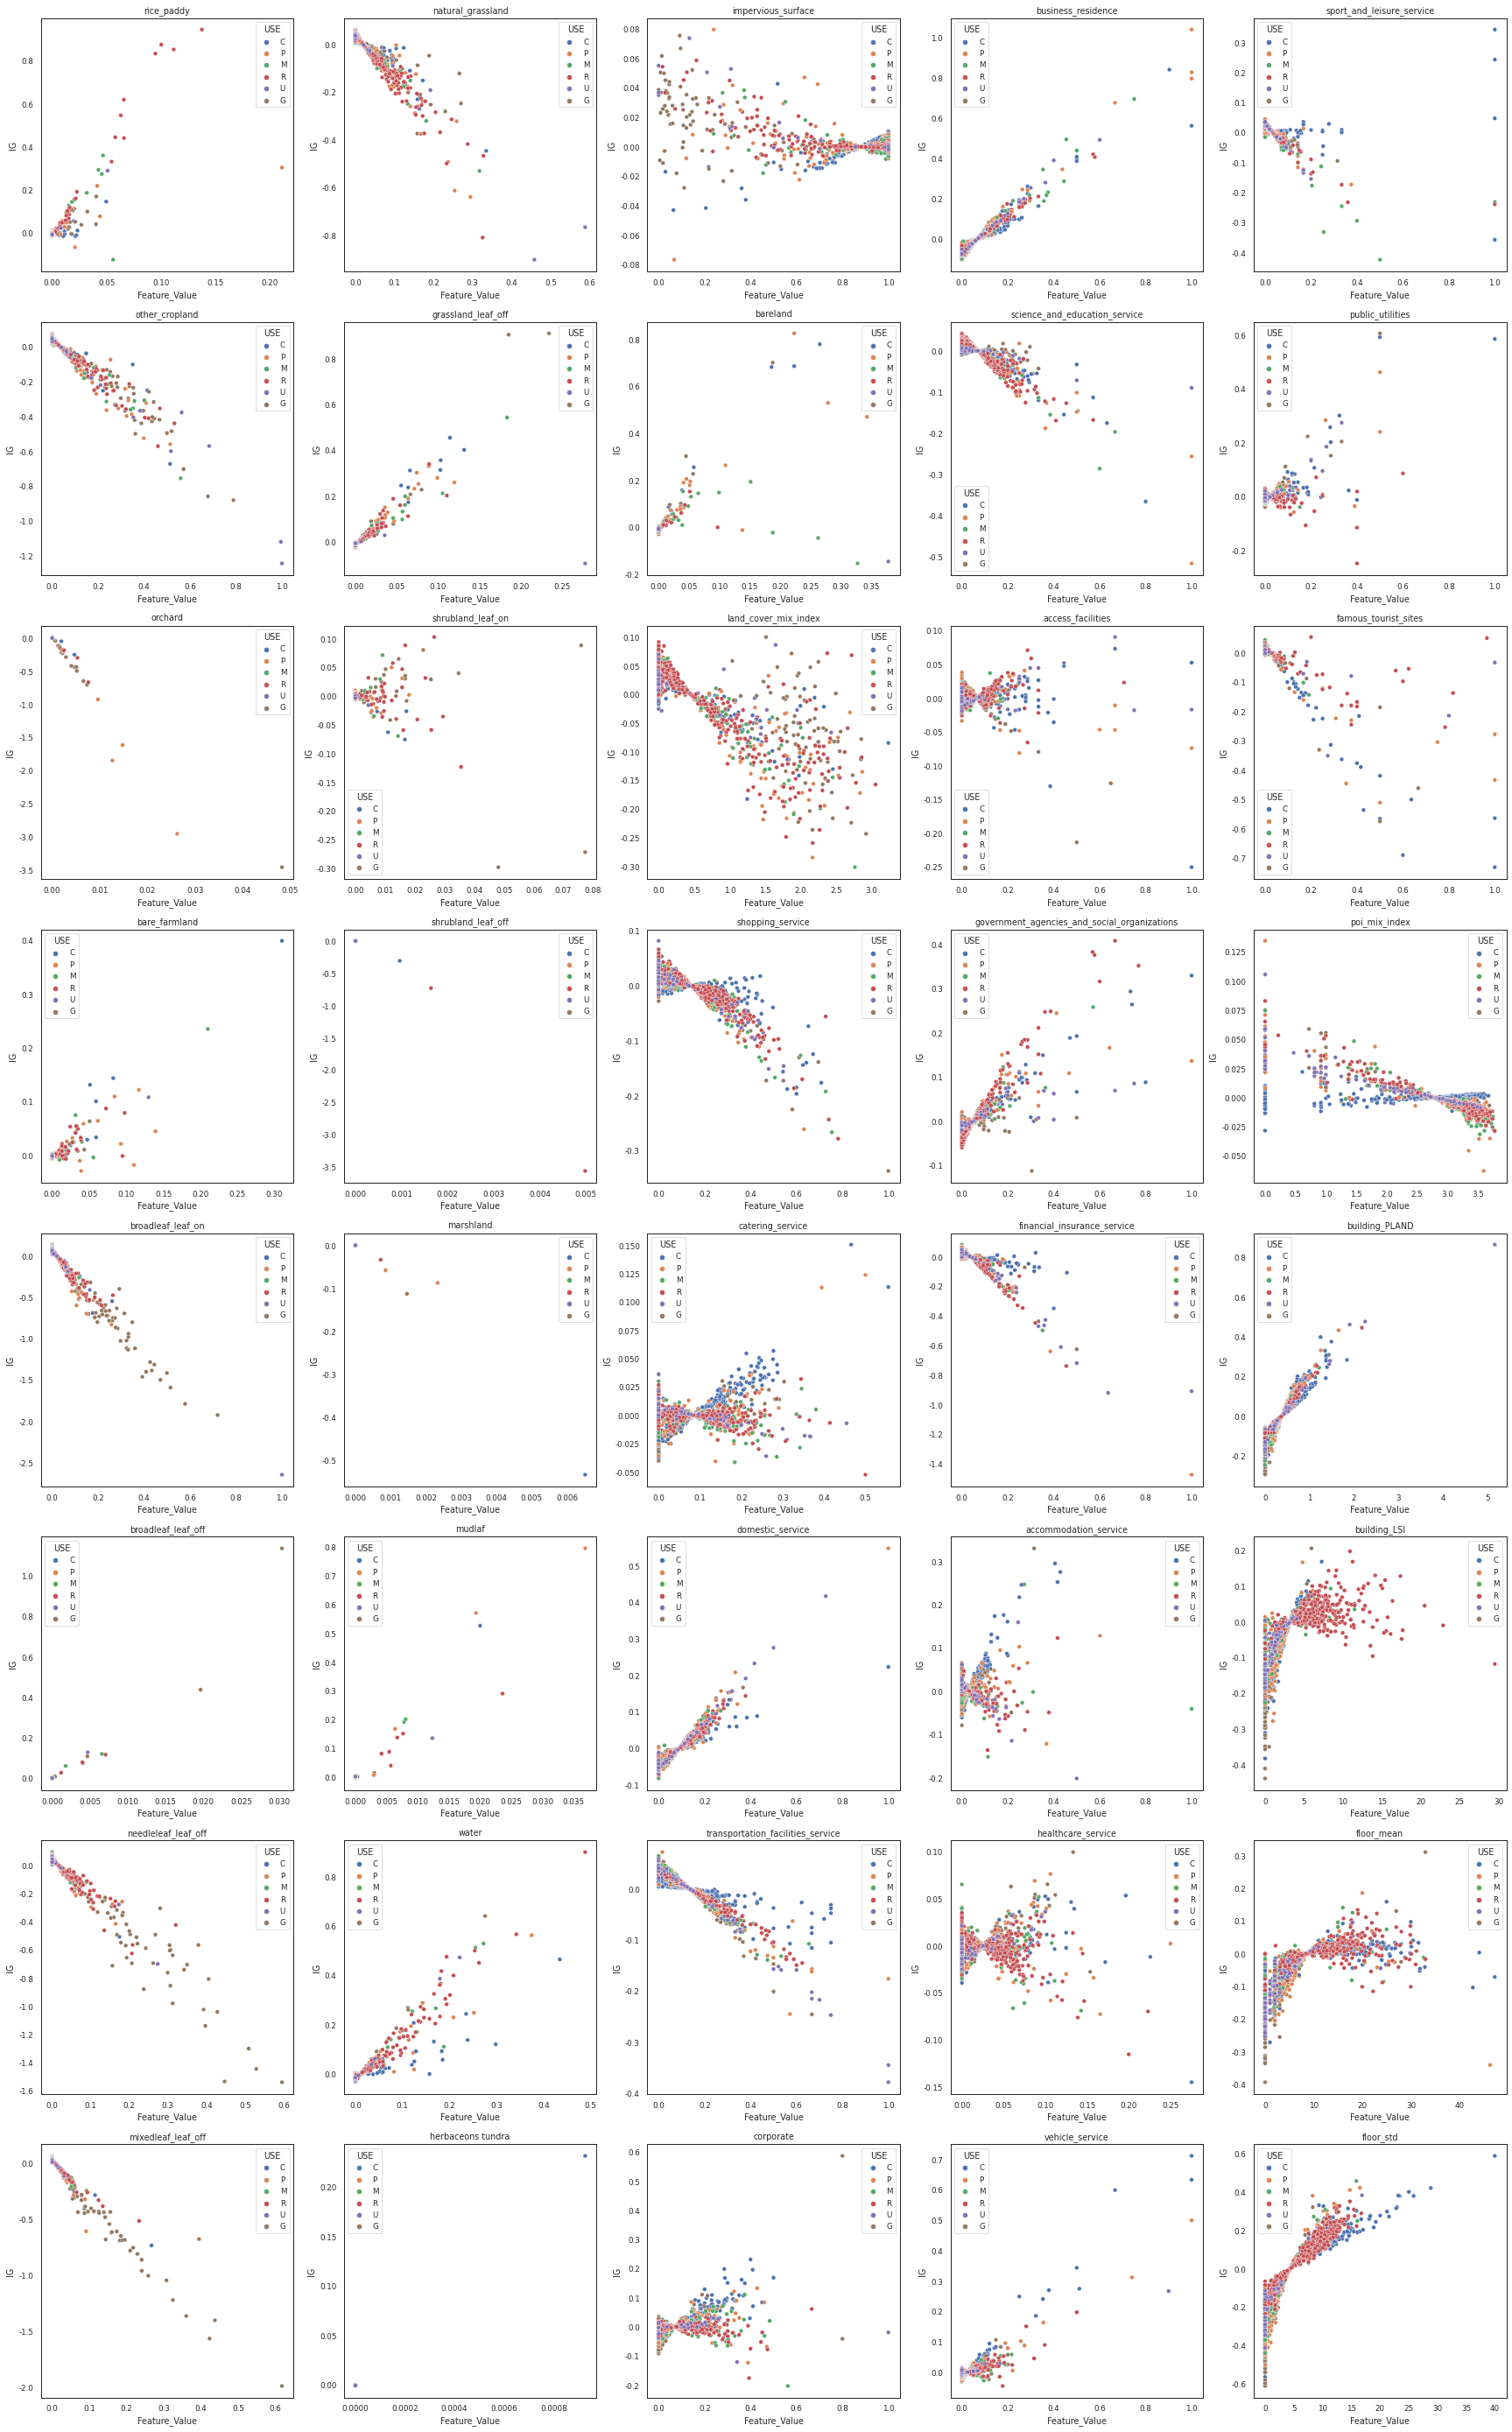

In [42]:
fig, ax = plt.subplots(8, 5, figsize=(30,50))
for i, name in enumerate(feature_names):
  display_feature_importance = {'IG': [], 'Feature_Value': [], 'USE': []}
  display_feature_importance['IG'] += list(self_igs[0][:, i])
  display_feature_importance['Feature_Value'] += list(X[name])
  display_feature_importance['USE'] += list(labels.loc[list(node_idx)])
  sns.scatterplot(data=display_feature_importance, y='IG', x='Feature_Value', hue='USE', ax=ax[i % 8][i // 8])
  ax[i % 8][i // 8].set_title(name)

Text(0.5, 0, 'Self IG Value for Commercial and Service Industry Land')

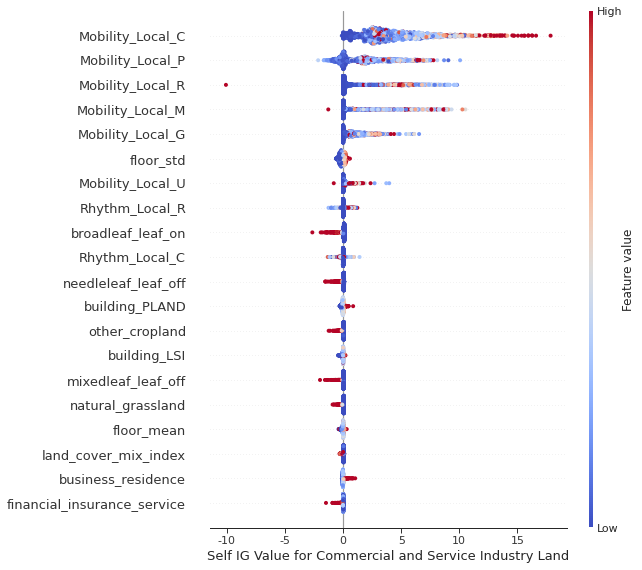

In [252]:
sns.set_style('white')
shap.summary_plot(np.concatenate((self_igs[0], direct_link_igs[:, 0].reshape((1514, 12))), axis=-1), X, show=False, cmap=plt.get_cmap('coolwarm'))
plt.xlabel('Self IG Value for Commercial and Service Industry Land')

Text(0.5, 0, 'Self IG Value for Commercial and Service Industry Land')

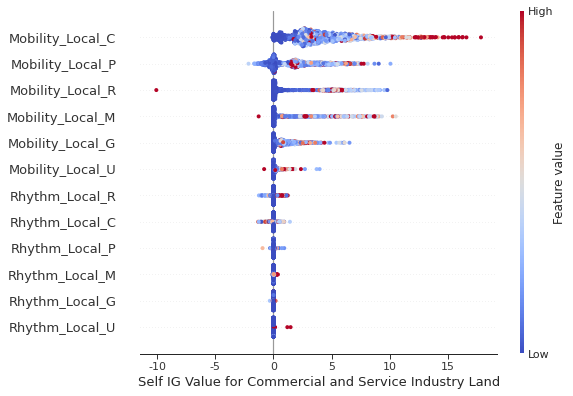

In [259]:
sns.set_style('white')
shap.summary_plot(direct_link_igs[:, 0].reshape((1514, 12)), X_net, show=False, cmap=plt.get_cmap('coolwarm'))
plt.xlabel('Self IG Value for Commercial and Service Industry Land')

Text(0.5, 0, 'Self IG Value for Commercial and Service Industry Land')

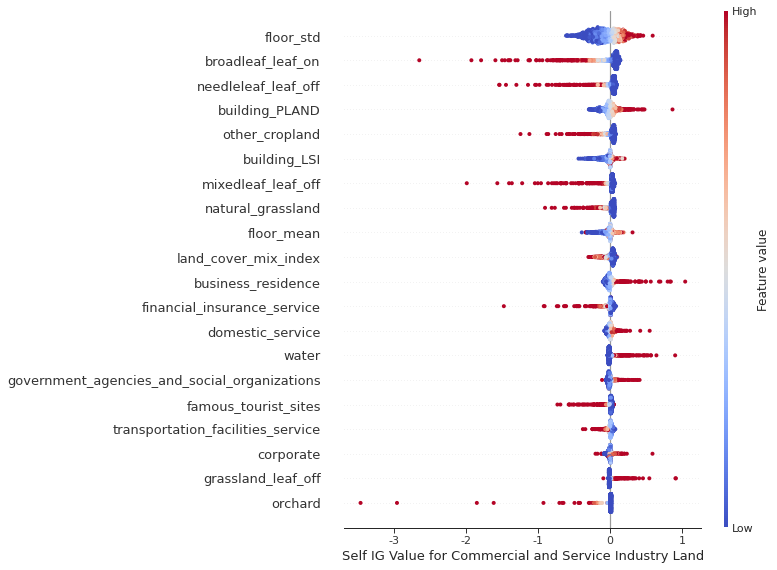

In [98]:
sns.set_style('white')
shap.summary_plot(self_igs[0], X, show=False, cmap=plt.get_cmap('coolwarm'))
plt.xlabel('Self IG Value for Commercial and Service Industry Land')

Text(0.5, 0, 'Self IG Value for Commercial and Service Industry Land')

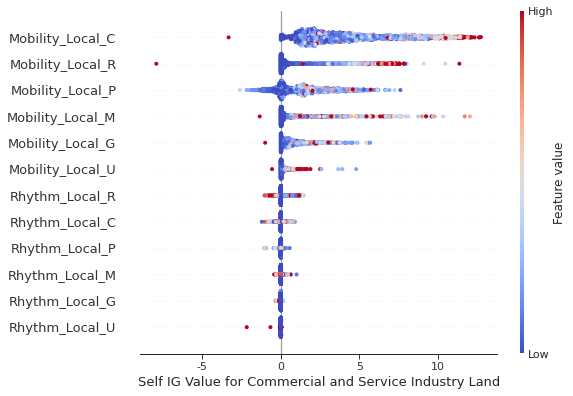

In [260]:
sns.set_style('white')
shap.summary_plot(direct_link_igs[:, 1].reshape((1514, 12)), X_net, show=False, cmap=plt.get_cmap('coolwarm'))
plt.xlabel('Self IG Value for Commercial and Service Industry Land')

Text(0.5, 0, 'Self IG Value for Green Space and Square Land')

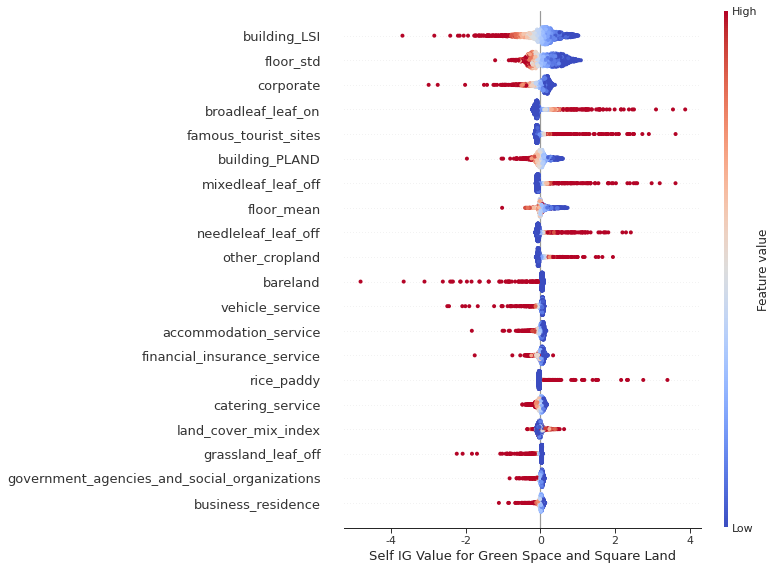

In [99]:
shap.summary_plot(self_igs[1], X, cmap=plt.get_cmap('coolwarm'), show=False)
plt.xlabel('Self IG Value for Green Space and Square Land')

Text(0.5, 0, 'Self IG Value for Commercial and Service Industry Land')

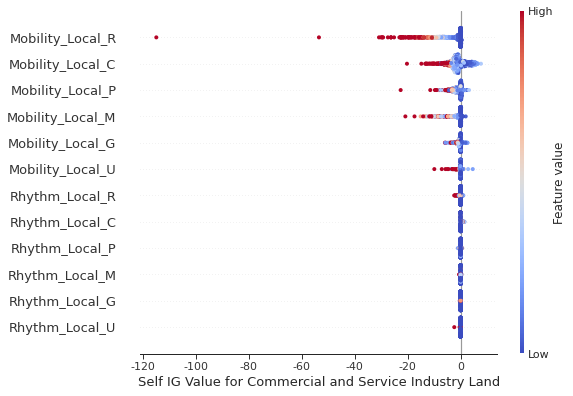

In [261]:
sns.set_style('white')
shap.summary_plot(direct_link_igs[:, 2].reshape((1514, 12)), X_net, show=False, cmap=plt.get_cmap('coolwarm'))
plt.xlabel('Self IG Value for Commercial and Service Industry Land')

Text(0.5, 0, 'Self IG Value for Industrial Land')

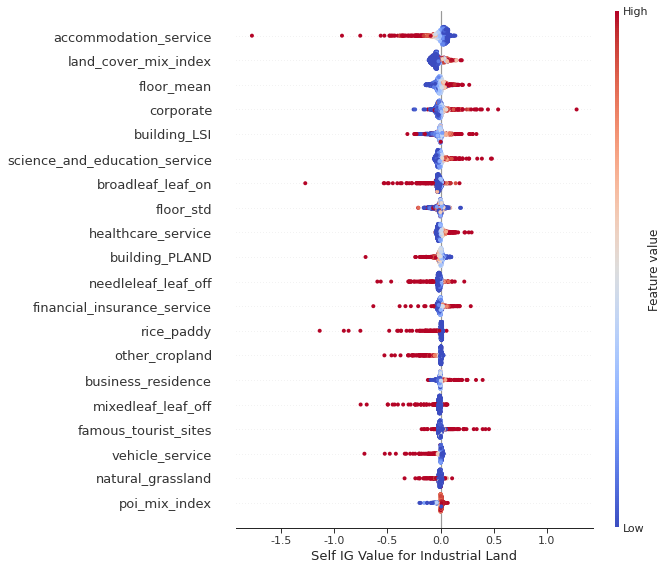

In [100]:
shap.summary_plot(self_igs[2], X, cmap=plt.get_cmap('coolwarm'), show=False)
plt.xlabel('Self IG Value for Industrial Land')

Text(0.5, 0, 'Self IG Value for Commercial and Service Industry Land')

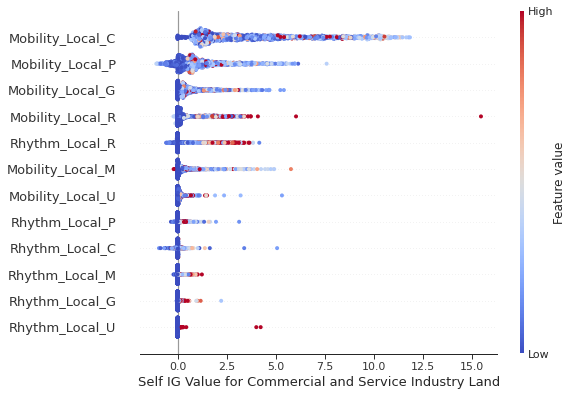

In [262]:
sns.set_style('white')
shap.summary_plot(direct_link_igs[:, 3].reshape((1514, 12)), X_net, show=False, cmap=plt.get_cmap('coolwarm'))
plt.xlabel('Self IG Value for Commercial and Service Industry Land')

Text(0.5, 0, 'Self IG Value for Public Management and Service Land')

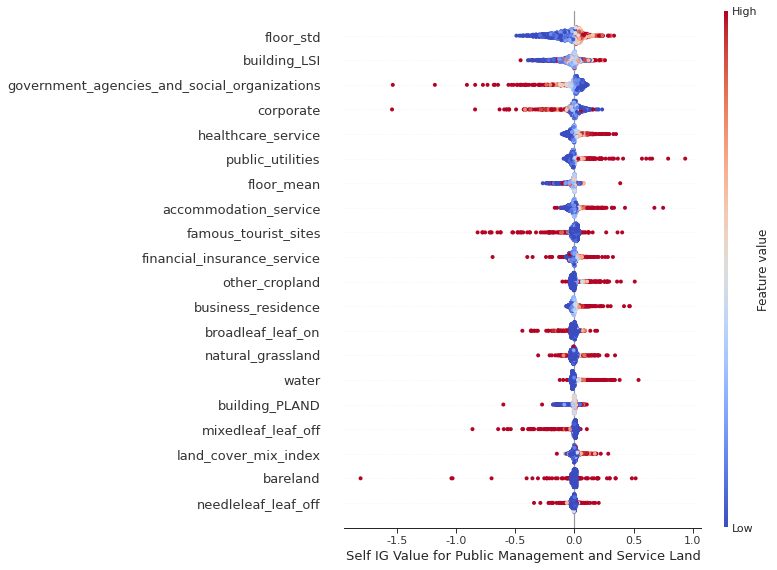

In [101]:
shap.summary_plot(self_igs[3], X, cmap=plt.get_cmap('coolwarm'), show=False)
plt.xlabel('Self IG Value for Public Management and Service Land')

Text(0.5, 0, 'Self IG Value for Commercial and Service Industry Land')

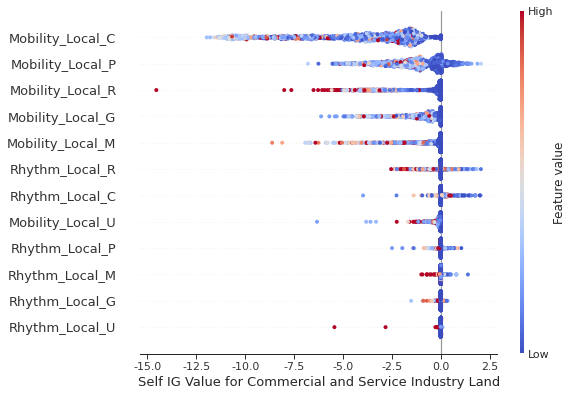

In [263]:
sns.set_style('white')
shap.summary_plot(direct_link_igs[:, 4].reshape((1514, 12)), X_net, show=False, cmap=plt.get_cmap('coolwarm'))
plt.xlabel('Self IG Value for Commercial and Service Industry Land')

Text(0.5, 0, 'Self IG Value for Residential Land')

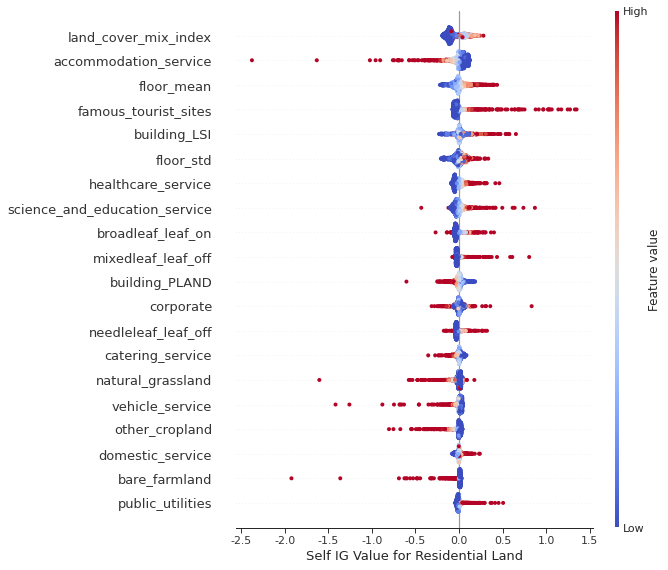

In [102]:
shap.summary_plot(self_igs[4], X, cmap=plt.get_cmap('coolwarm'), show=False)
plt.xlabel('Self IG Value for Residential Land')

Text(0.5, 0, 'Self IG Value for Commercial and Service Industry Land')

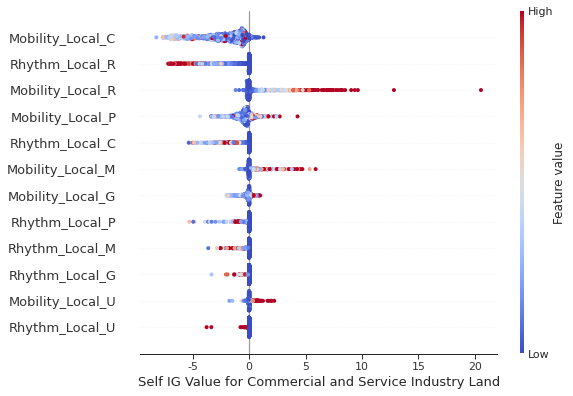

In [264]:
sns.set_style('white')
shap.summary_plot(direct_link_igs[:, 5].reshape((1514, 12)), X_net, show=False, cmap=plt.get_cmap('coolwarm'))
plt.xlabel('Self IG Value for Commercial and Service Industry Land')

Text(0.5, 0, 'Self IG Value for Municipal Utilities Land')

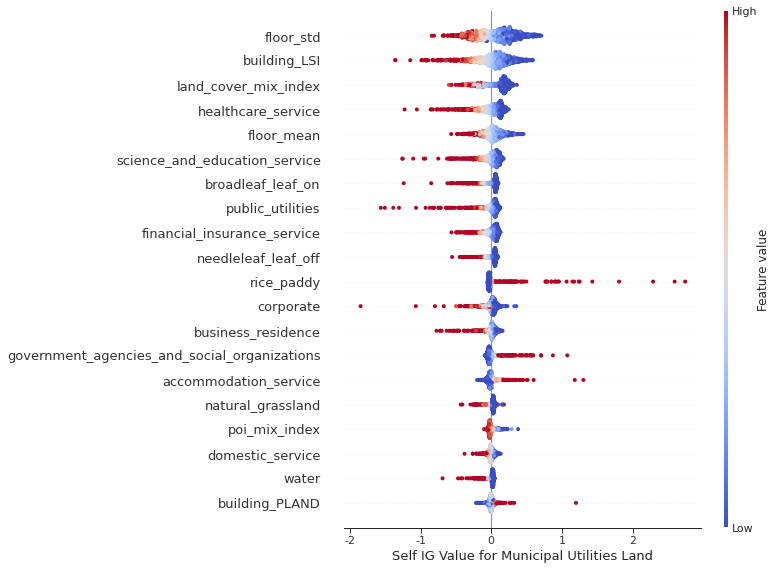

In [103]:
shap.summary_plot(self_igs[5], X, cmap=plt.get_cmap('coolwarm'), show=False)
plt.xlabel('Self IG Value for Municipal Utilities Land')

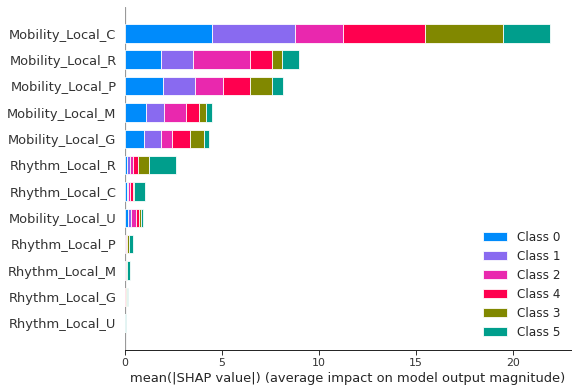

In [268]:
shap.summary_plot([direct_link_igs[:, i].reshape((1514, 12)) for i in range(6)], X_net.columns, plot_type="bar")

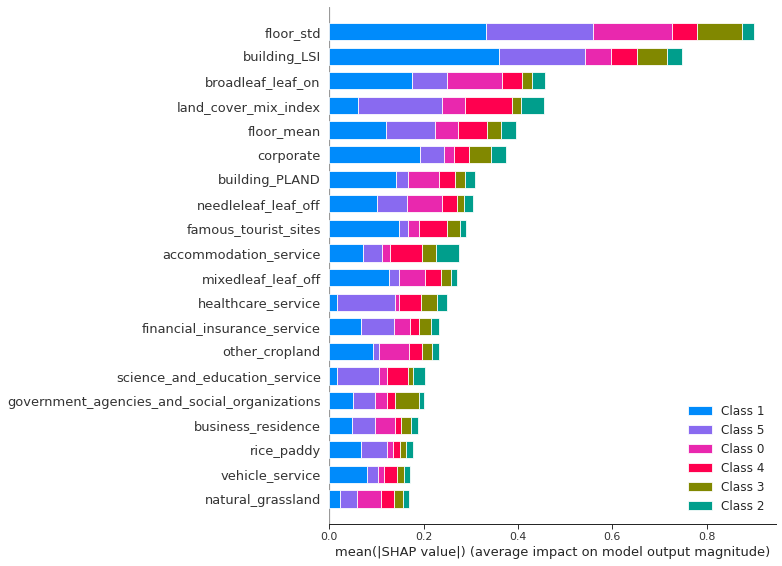

In [104]:
shap.summary_plot(list(self_igs), X.columns, plot_type="bar")

# Feature Context

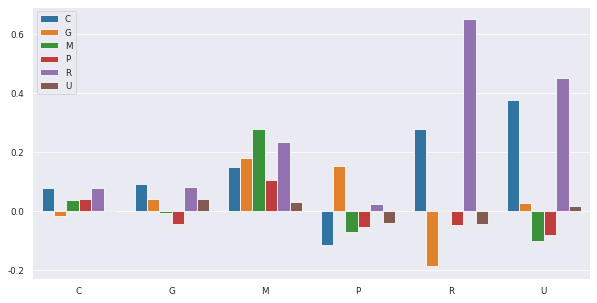

In [105]:
neighbor_mean = {'Class': [], 'Mean_IG': [], 'Task': []}
for i, c in enumerate(c_true_idx):
  tmp = [node_igs[c, i, :][:, cc].sum(-1).mean() for cc in c_true_idx]
  tmp[i] -= node_igs[c, i, c].mean()
  neighbor_mean['Mean_IG'] += tmp
  neighbor_mean['Class'] += classes
  neighbor_mean['Task'] += [classes[i]] * 6
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=neighbor_mean, x='Task', y='Mean_IG', hue='Class', palette=sns.color_palette("tab10"))

Text(0.5, 0, 'IG Vlaue')

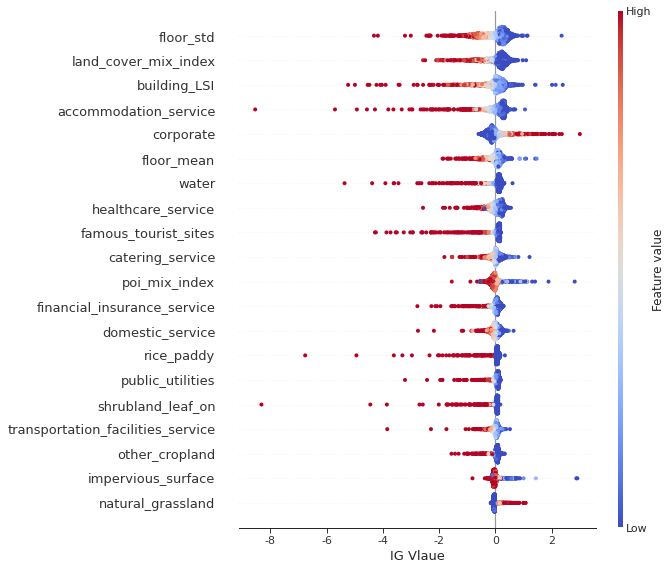

In [106]:
sns.set_style('white')
shap.summary_plot(feature_igs[0], X, cmap=plt.get_cmap('coolwarm'), show=False)
plt.xlabel('IG Vlaue')

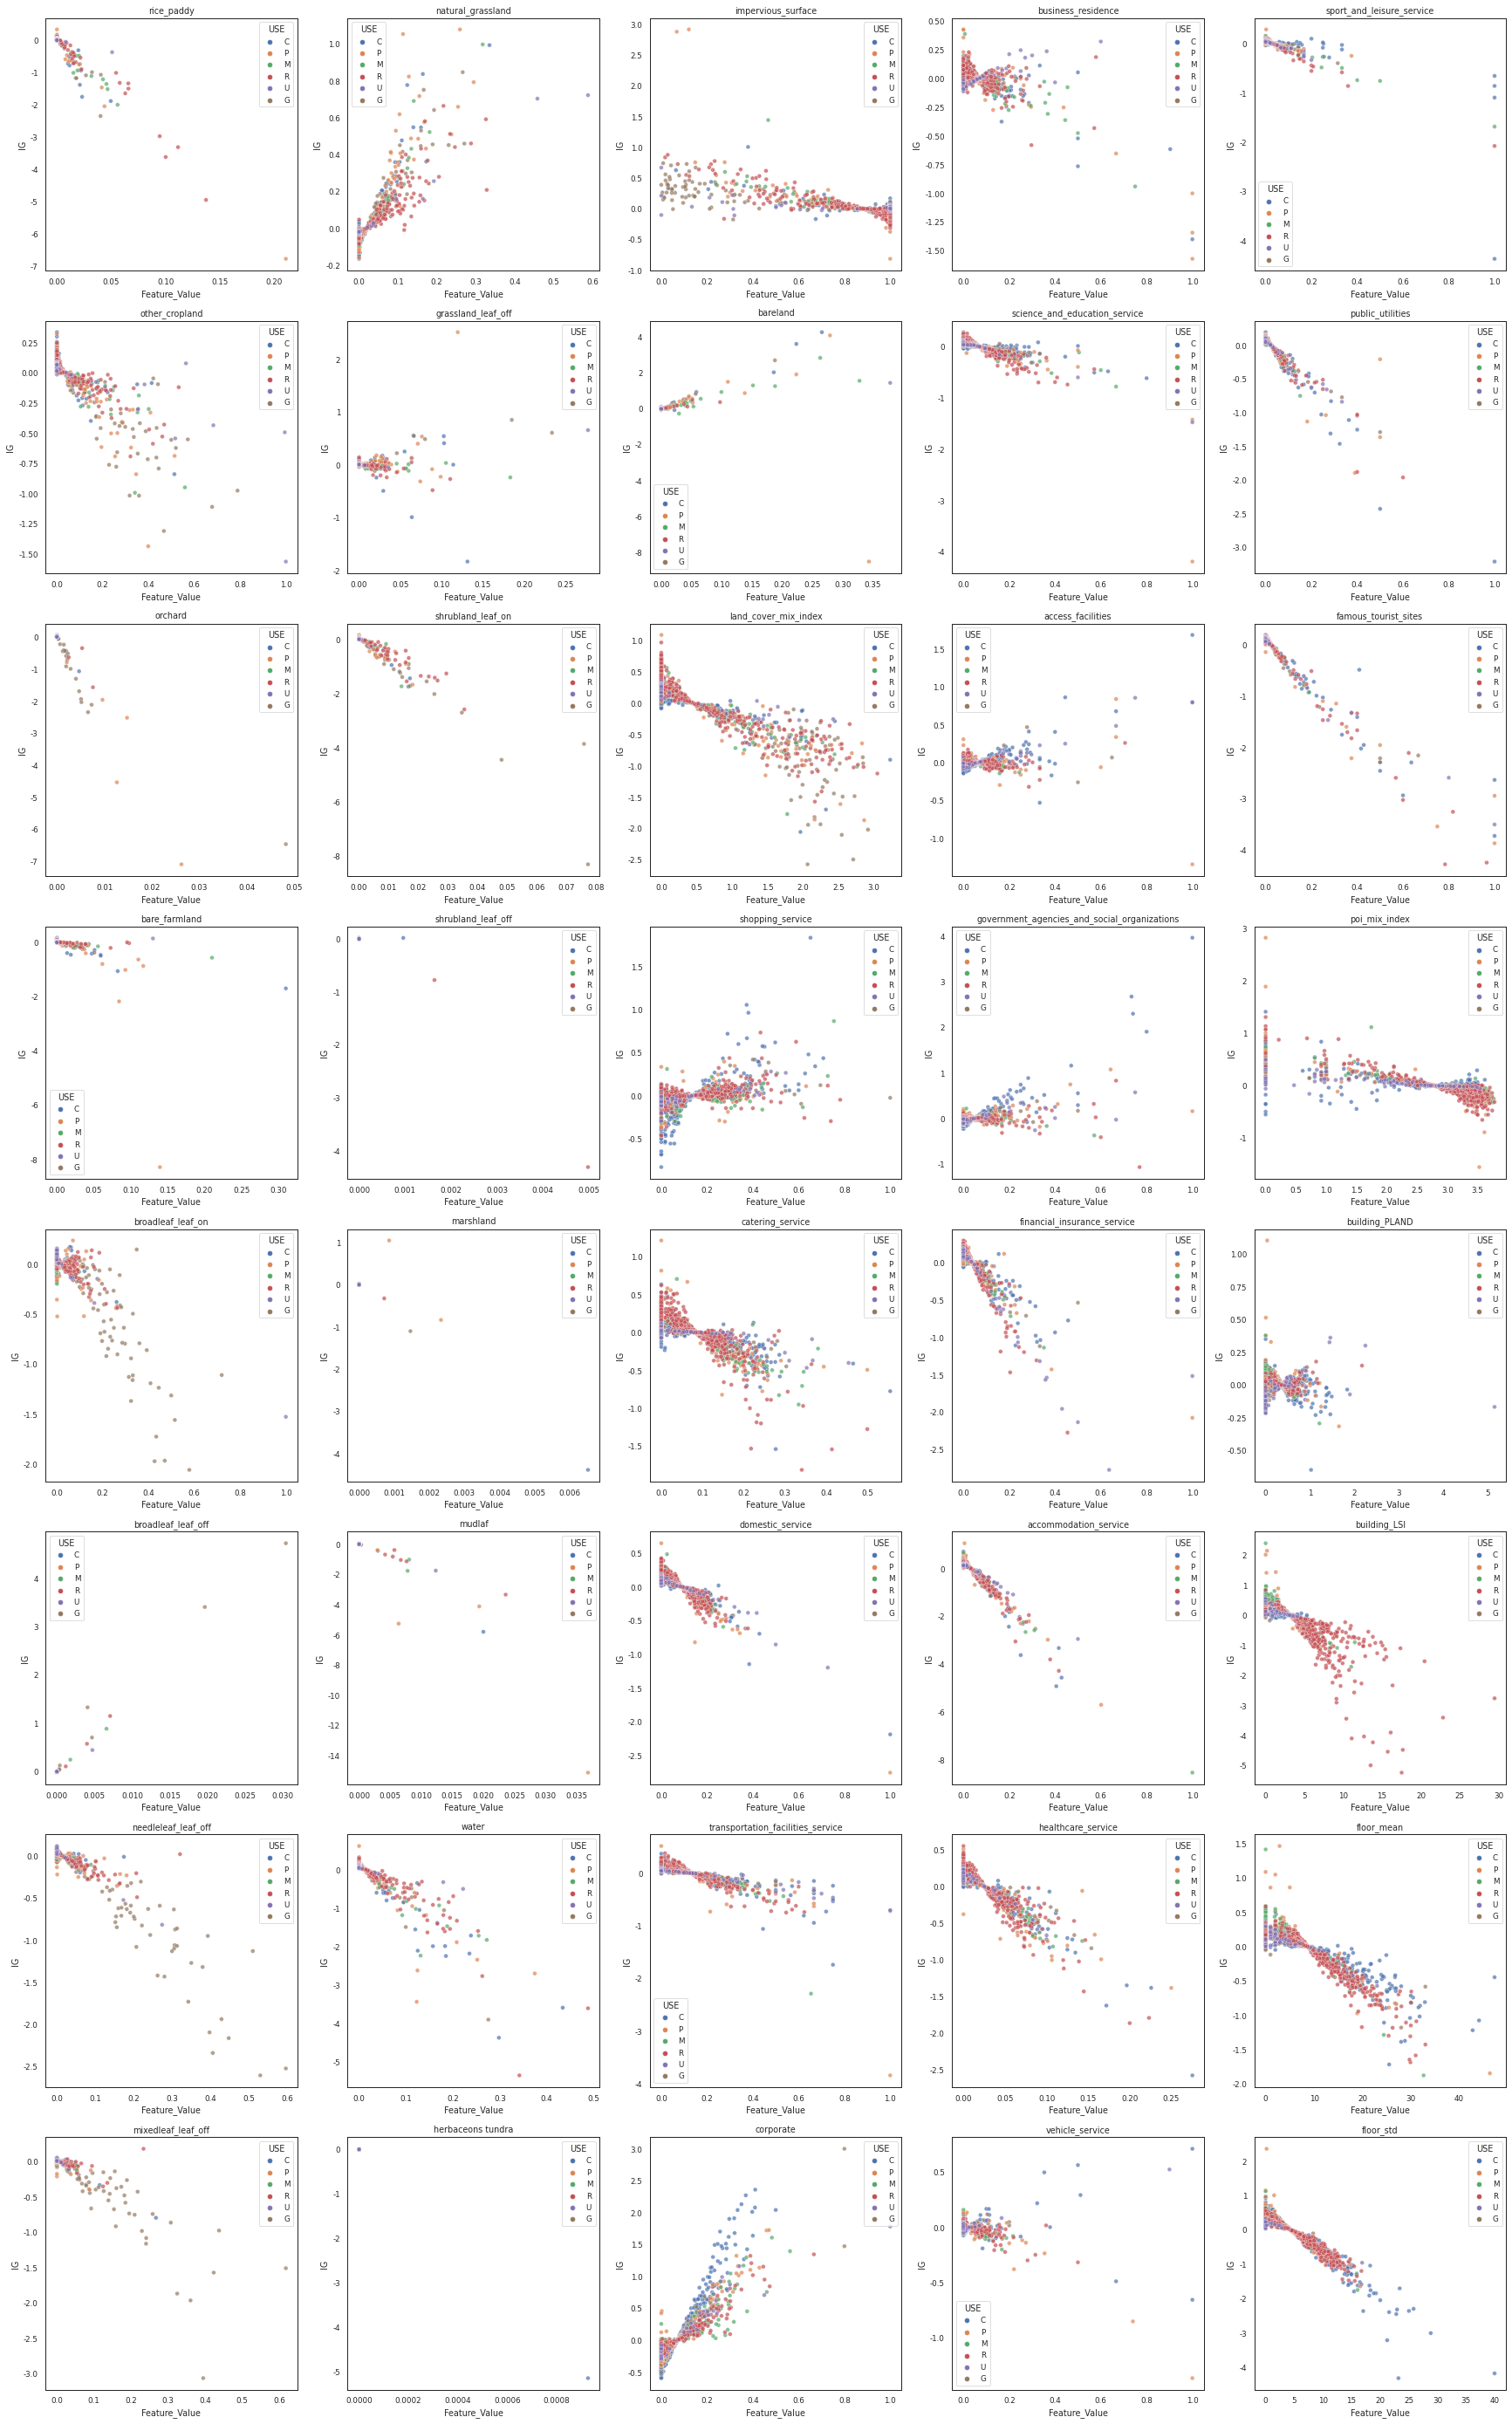

In [50]:
fig, ax = plt.subplots(8, 5, figsize=(30,50))
for i, name in enumerate(feature_names):
  display_feature_importance = {'IG': [], 'Feature_Value': [], 'USE': []}
  display_feature_importance['IG'] += list(feature_igs[0][:, i])
  display_feature_importance['Feature_Value'] += list(X[name])
  # display_feature_importance['USE'] += [classes[c] for c in c_pred]
  display_feature_importance['USE'] += list(labels.loc[list(node_idx)])
  sns.scatterplot(data=display_feature_importance, y='IG', x='Feature_Value', hue='USE', ax=ax[i % 8][i // 8], alpha=.7)
  ax[i % 8][i // 8].set_title(name)

Text(0.5, 0, 'IG Vlaue')

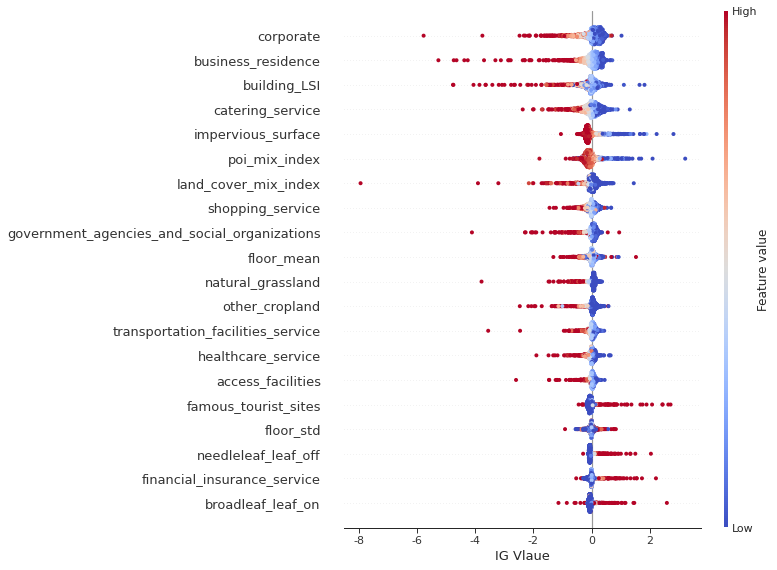

In [107]:
shap.summary_plot(feature_igs[1], X, cmap=plt.get_cmap('coolwarm'), show=False)
plt.xlabel('IG Vlaue')

Text(0.5, 0, 'IG Vlaue')

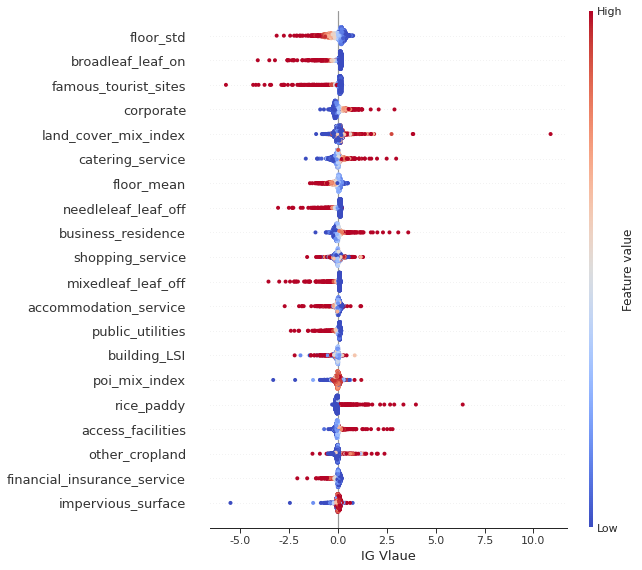

In [108]:
shap.summary_plot(feature_igs[2], X, cmap=plt.get_cmap('coolwarm'), show=False)
plt.xlabel('IG Vlaue')

Text(0.5, 0, 'IG Vlaue')

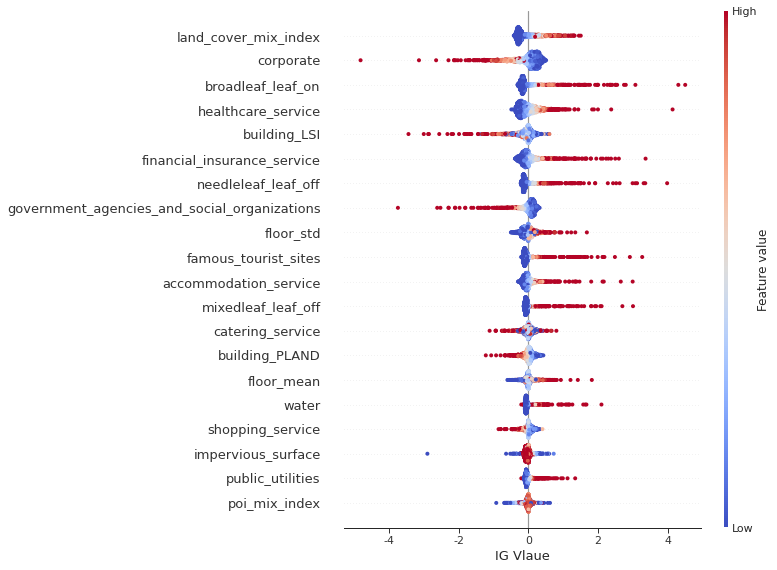

In [109]:
shap.summary_plot(feature_igs[3], X, cmap=plt.get_cmap('coolwarm'), show=False)
plt.xlabel('IG Vlaue')

Text(0.5, 0, 'IG Vlaue')

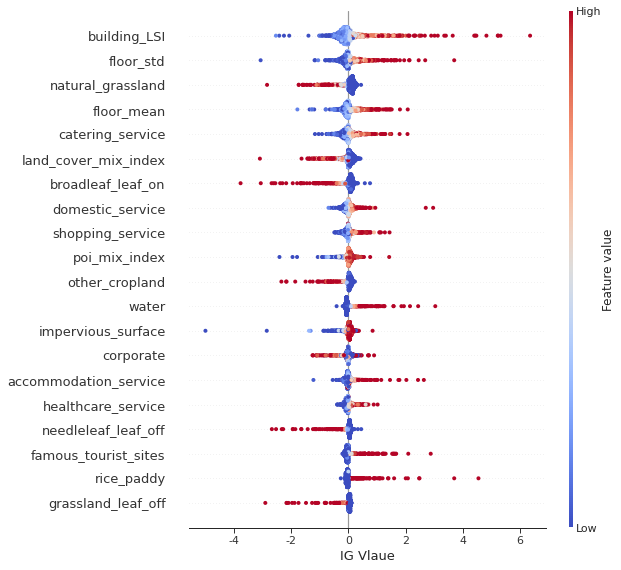

In [110]:
shap.summary_plot(feature_igs[4], X, cmap=plt.get_cmap('coolwarm'), show=False)
plt.xlabel('IG Vlaue')

Text(0.5, 0, 'IG Vlaue')

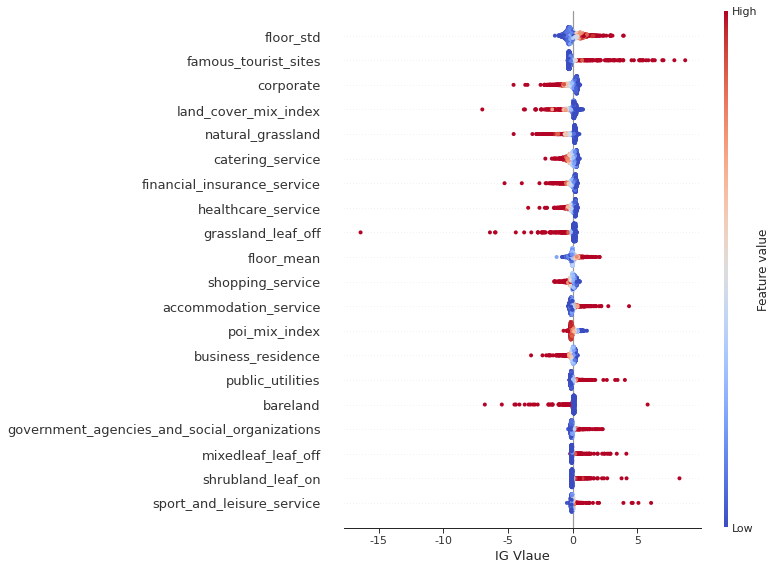

In [111]:
shap.summary_plot(feature_igs[5], X, cmap=plt.get_cmap('coolwarm'), show=False)
plt.xlabel('IG Vlaue')

# Link

In [83]:
link_classes = np.array([[f'{j}-{i}' for i in classes] for j in classes]).flatten()

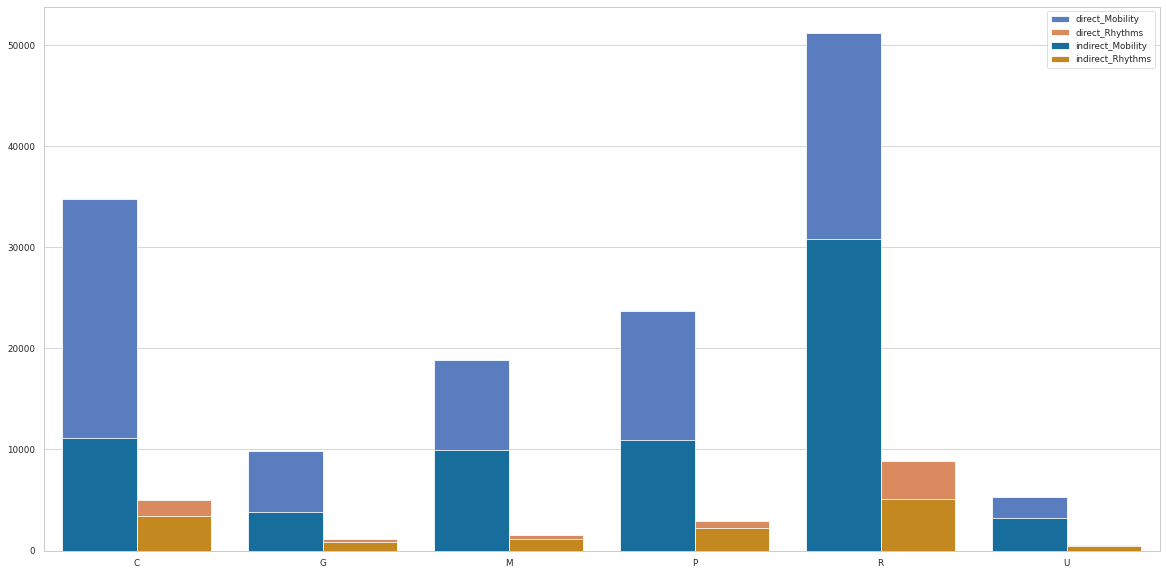

In [67]:
networks = ['Mobility', 'Rhythms']
network_importance_display = {'Network': [], 'Class': [], 'IGs':[]}
for i in range(6):
  for j in range(2):
    network_importance_display['Network'].append(f'direct_{networks[j]}')
    network_importance_display['Class'].append(classes[i])
    network_importance_display['IGs'].append(abs(indirect_link_igs)[c_true_idx[i]].sum(0).sum(0).sum(0)[j] + abs(direct_link_igs)[c_true_idx[i]].sum(0).sum(0).sum(1)[j])
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=network_importance_display, x='Class', y='IGs', hue='Network', palette=sns.color_palette('muted', 2))

network_importance_display = {'Network': [], 'Class': [], 'IGs':[]}
for i in range(6):
  for j in range(2):
    network_importance_display['Network'].append(f'indirect_{networks[j]}')
    network_importance_display['Class'].append(classes[i])
    network_importance_display['IGs'].append(abs(indirect_link_igs)[c_true_idx[i]].sum(0).sum(0).sum(0)[j])
sns.set_style('whitegrid')
sns.barplot(data=network_importance_display, x='Class', y='IGs', hue='Network', palette=sns.color_palette('colorblind', 2))

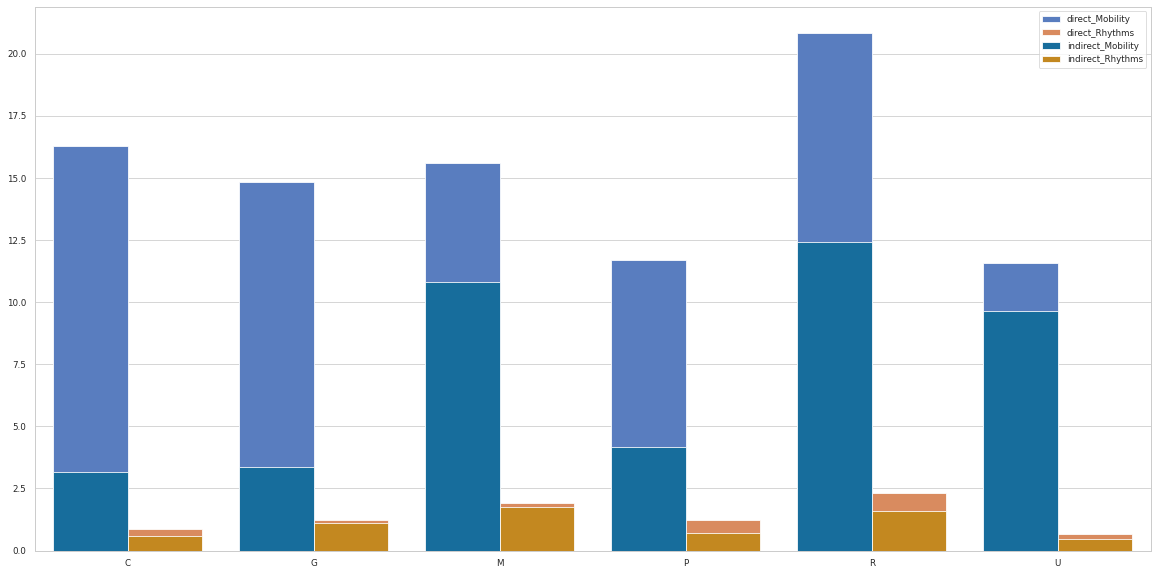

In [69]:
network_importance_display = {'Network': [], 'Class': [], 'IGs':[]}
for i in range(6):
  for j in range(2):
    network_importance_display['Network'].append(f'direct_{networks[j]}')
    network_importance_display['Class'].append(classes[i])
    network_importance_display['IGs'].append((abs(indirect_link_igs)[c_true_idx[i]].sum(0)[i].sum(0)[j] + abs(direct_link_igs)[c_true_idx[i]].sum(0)[i].sum(1)[j]) / len(c_true_idx[i]))
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=network_importance_display, x='Class', y='IGs', hue='Network', palette=sns.color_palette('muted', 2))

network_importance_display = {'Network': [], 'Class': [], 'IGs':[]}
for i in range(6):
  for j in range(2):
    network_importance_display['Network'].append(f'indirect_{networks[j]}')
    network_importance_display['Class'].append(classes[i])
    network_importance_display['IGs'].append(abs(indirect_link_igs)[c_true_idx[i]].sum(0)[i].sum(0)[j] / len(c_true_idx[i]))
sns.set_style('whitegrid')
sns.barplot(data=network_importance_display, x='Class', y='IGs', hue='Network', palette=sns.color_palette('colorblind', 2))

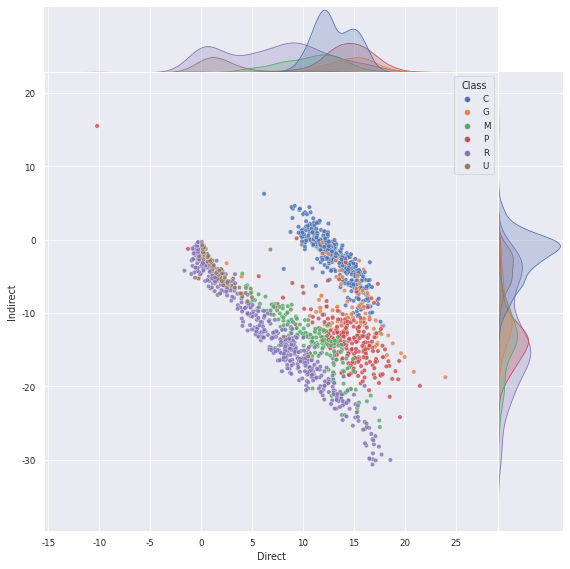

In [70]:
c = 0
net = 0
direct_indirect = {'Direct': [], 'Indirect': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  direct_indirect['Direct'].append(direct_link_igs[i][c].sum(1)[net])
  direct_indirect['Indirect'].append(indirect_link_igs[i][c].sum(0)[net])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Direct', y='Indirect', data=pd.DataFrame(direct_indirect, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

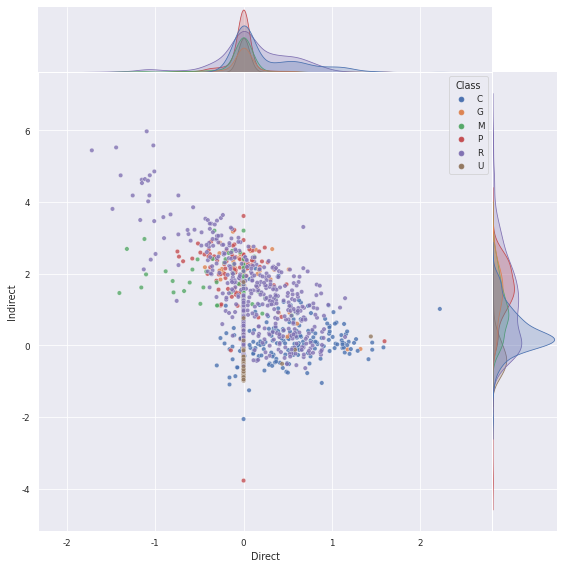

In [71]:
c = 0
net = 1
direct_indirect = {'Direct': [], 'Indirect': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  direct_indirect['Direct'].append(direct_link_igs[i][c].sum(1)[net])
  direct_indirect['Indirect'].append(indirect_link_igs[i][c].sum(0)[net])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Direct', y='Indirect', data=pd.DataFrame(direct_indirect, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

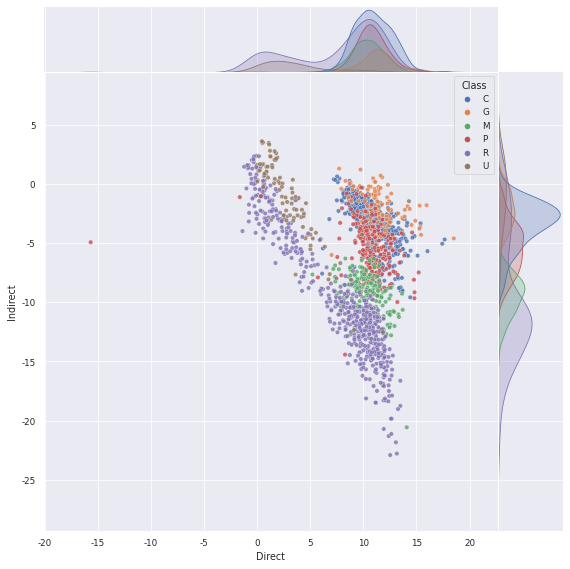

In [72]:
c = 1
net = 0
direct_indirect = {'Direct': [], 'Indirect': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  direct_indirect['Direct'].append(direct_link_igs[i][c].sum(1)[net])
  direct_indirect['Indirect'].append(indirect_link_igs[i][c].sum(0)[net])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Direct', y='Indirect', data=pd.DataFrame(direct_indirect, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

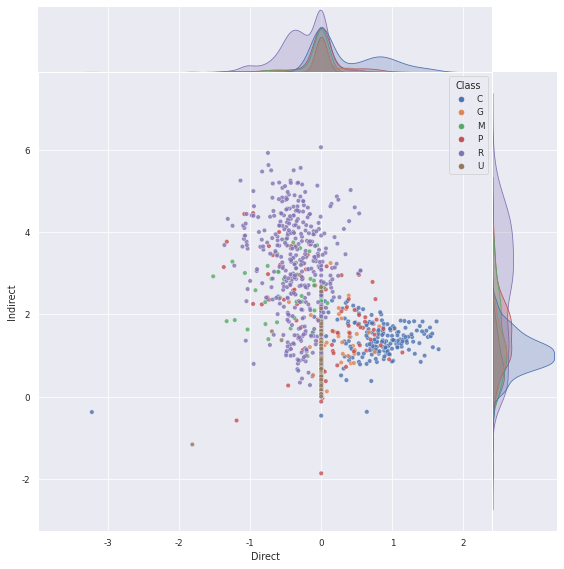

In [73]:
c = 1
net = 1
direct_indirect = {'Direct': [], 'Indirect': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  direct_indirect['Direct'].append(direct_link_igs[i][c].sum(1)[net])
  direct_indirect['Indirect'].append(indirect_link_igs[i][c].sum(0)[net])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Direct', y='Indirect', data=pd.DataFrame(direct_indirect, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

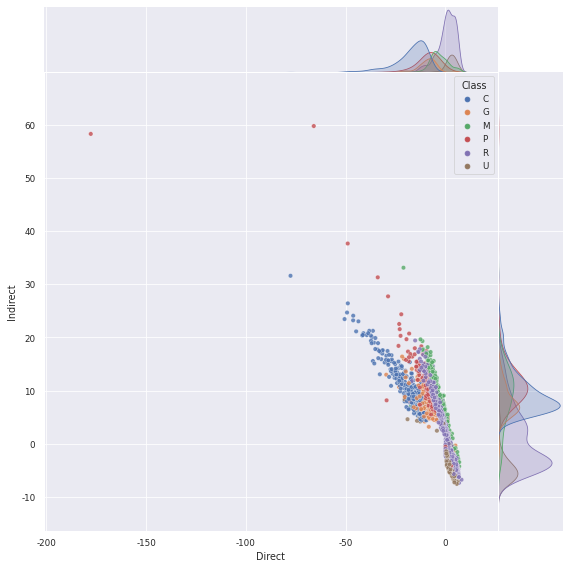

In [74]:
c = 2
net = 0
direct_indirect = {'Direct': [], 'Indirect': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  direct_indirect['Direct'].append(direct_link_igs[i][c].sum(1)[net])
  direct_indirect['Indirect'].append(indirect_link_igs[i][c].sum(0)[net])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Direct', y='Indirect', data=pd.DataFrame(direct_indirect, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

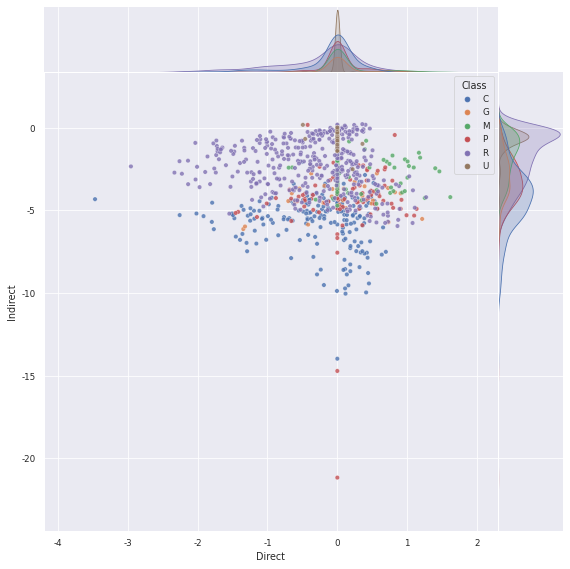

In [75]:
c = 2
net = 1
direct_indirect = {'Direct': [], 'Indirect': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  direct_indirect['Direct'].append(direct_link_igs[i][c].sum(1)[net])
  direct_indirect['Indirect'].append(indirect_link_igs[i][c].sum(0)[net])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Direct', y='Indirect', data=pd.DataFrame(direct_indirect, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

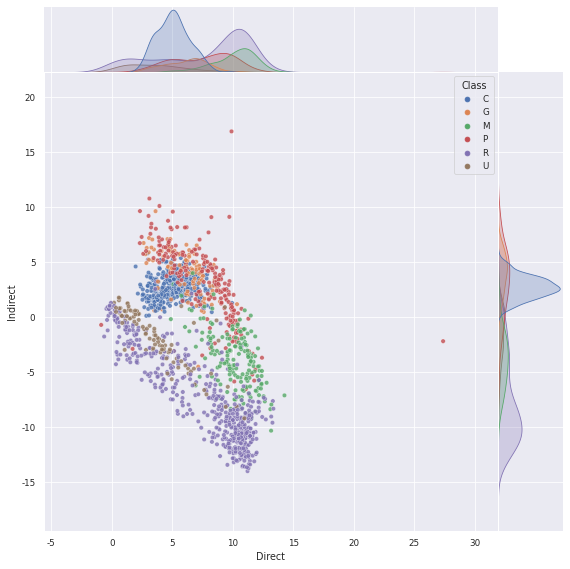

In [76]:
c = 3
net = 0
direct_indirect = {'Direct': [], 'Indirect': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  direct_indirect['Direct'].append(direct_link_igs[i][c].sum(1)[net])
  direct_indirect['Indirect'].append(indirect_link_igs[i][c].sum(0)[net])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Direct', y='Indirect', data=pd.DataFrame(direct_indirect, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

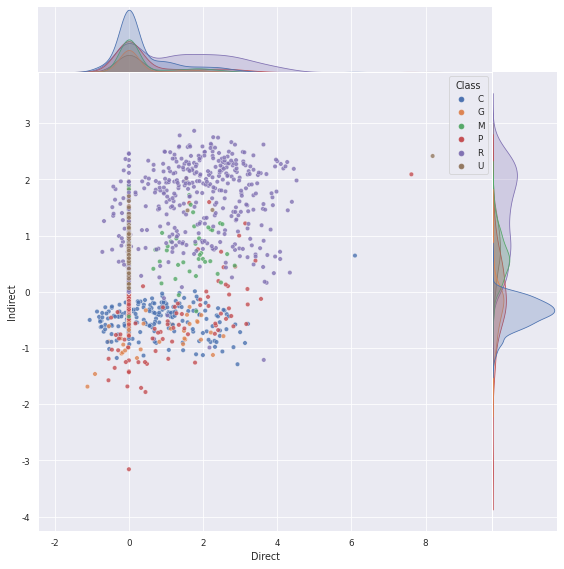

In [77]:
c = 3
net = 1
direct_indirect = {'Direct': [], 'Indirect': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  direct_indirect['Direct'].append(direct_link_igs[i][c].sum(1)[net])
  direct_indirect['Indirect'].append(indirect_link_igs[i][c].sum(0)[net])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Direct', y='Indirect', data=pd.DataFrame(direct_indirect, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

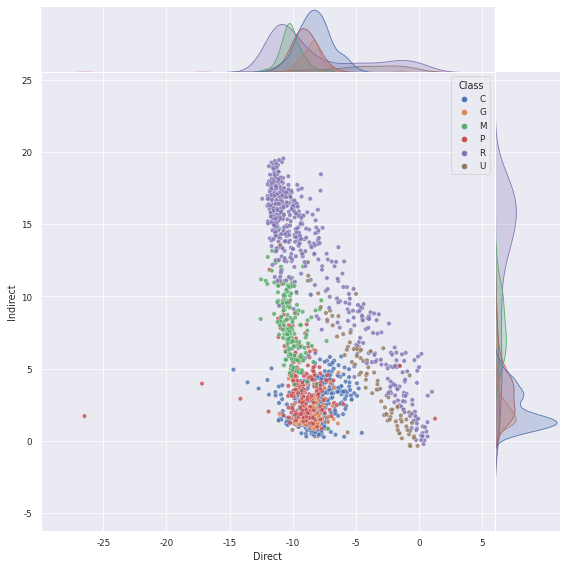

In [78]:
c = 4
net = 0
direct_indirect = {'Direct': [], 'Indirect': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  direct_indirect['Direct'].append(direct_link_igs[i][c].sum(1)[net])
  direct_indirect['Indirect'].append(indirect_link_igs[i][c].sum(0)[net])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Direct', y='Indirect', data=pd.DataFrame(direct_indirect, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

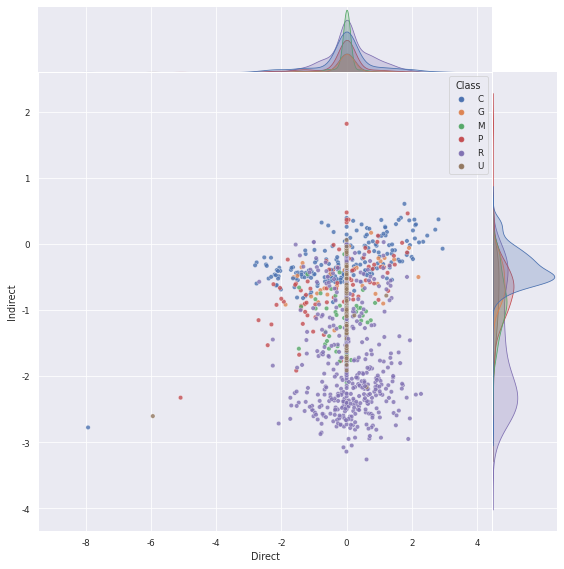

In [79]:
c = 4
net = 1
direct_indirect = {'Direct': [], 'Indirect': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  direct_indirect['Direct'].append(direct_link_igs[i][c].sum(1)[net])
  direct_indirect['Indirect'].append(indirect_link_igs[i][c].sum(0)[net])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Direct', y='Indirect', data=pd.DataFrame(direct_indirect, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

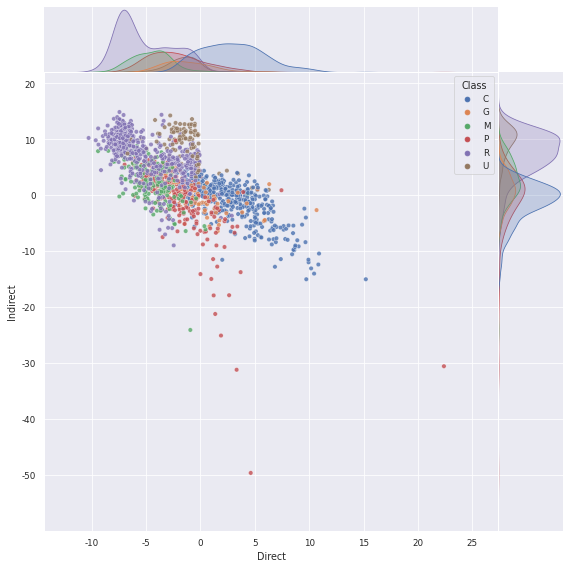

In [80]:
c = 5
net = 0
direct_indirect = {'Direct': [], 'Indirect': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  direct_indirect['Direct'].append(direct_link_igs[i][c].sum(1)[net])
  direct_indirect['Indirect'].append(indirect_link_igs[i][c].sum(0)[net])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Direct', y='Indirect', data=pd.DataFrame(direct_indirect, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

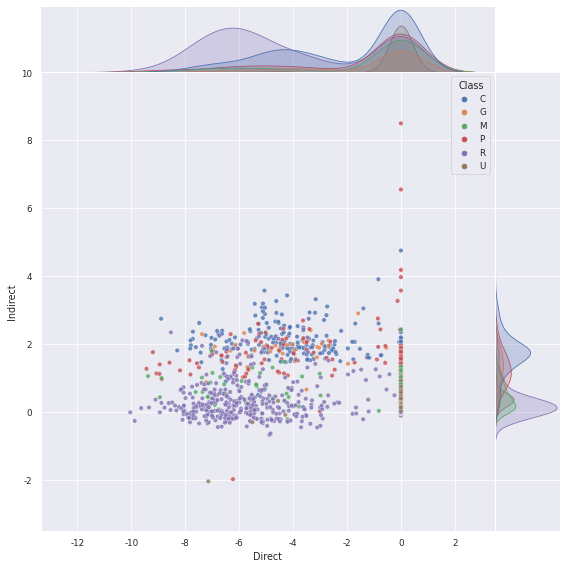

In [81]:
c = 5
net = 1
direct_indirect = {'Direct': [], 'Indirect': [], 'Class': list(labels[node_idx].values)}
for i in range(1514):
  direct_indirect['Direct'].append(direct_link_igs[i][c].sum(1)[net])
  direct_indirect['Indirect'].append(indirect_link_igs[i][c].sum(0)[net])
sns.set_style("darkgrid")
sns.set_context("paper")
sns.jointplot(x='Direct', y='Indirect', data=pd.DataFrame(direct_indirect, index=list(range(1514))), hue='Class', s=20, alpha=.8, hue_order=classes, height=8, space=0, ratio=7)

Text(0.5, 1.0, 'IGs of Indirect Links')

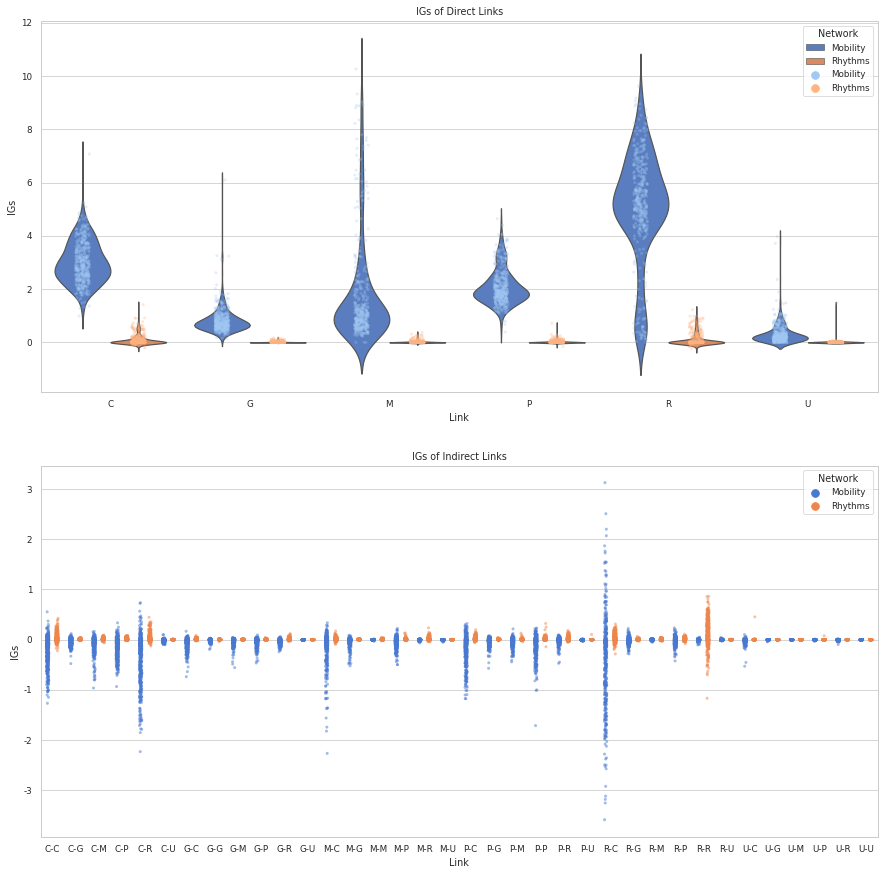

In [85]:
c = 0
sns.set_style('whitegrid')
f, ax = plt.subplots(2, 1, figsize=(15, 15))
display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([direct_link_igs[c_true_idx[c], c, i, :].flatten() for i in range(2)]).astype(float), Link=list(classes) * (2 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(classes) * len(c_true_idx[c])) for i in networks])))
# ax = sns.boxplot(data=display_link_igs, y='VALUE', x='LINK', hue='NETWORK', dodge=True, width=.5)
sns.violinplot(data=display_link_igs, y='IGs', x='Link', hue='Network', scale='width', inner=None, palette=sns.color_palette('muted', 2), bw=.3, ax=ax[0])
sns.stripplot(data=display_link_igs, y='IGs', x='Link', hue='Network', dodge=True, jitter=True, size=3, alpha=.3, palette=sns.color_palette('pastel', 2), ax=ax[0])
display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([indirect_link_igs[c_true_idx[c], c, :, i].flatten() for i in range(2)]), Link=list(link_classes) * (2 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(link_classes) * len(c_true_idx[c])) for i in networks])))
sns.stripplot(data=display_link_igs, y='IGs', x='Link', hue='Network', dodge=True, jitter=True, alpha=.5, size=3, ax=ax[1], palette=sns.color_palette('muted', 2))
# display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([link_igs[c_true_idx[c], c, :, i].mean(0) for i in range(3)]), Link=list(link_classes) * (3 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(link_classes) * len(c_true_idx[c])) for i in ['Interaction', 'Spatial', 'Time']])))
# ax = sns.barplot(data=display_link_igs, y='IGs', x='Link', hue='Network')
ax[0].set_title('IGs of Direct Links')
ax[1].set_title('IGs of Indirect Links')

Text(0.5, 1.0, 'IGs of Indirect Links')

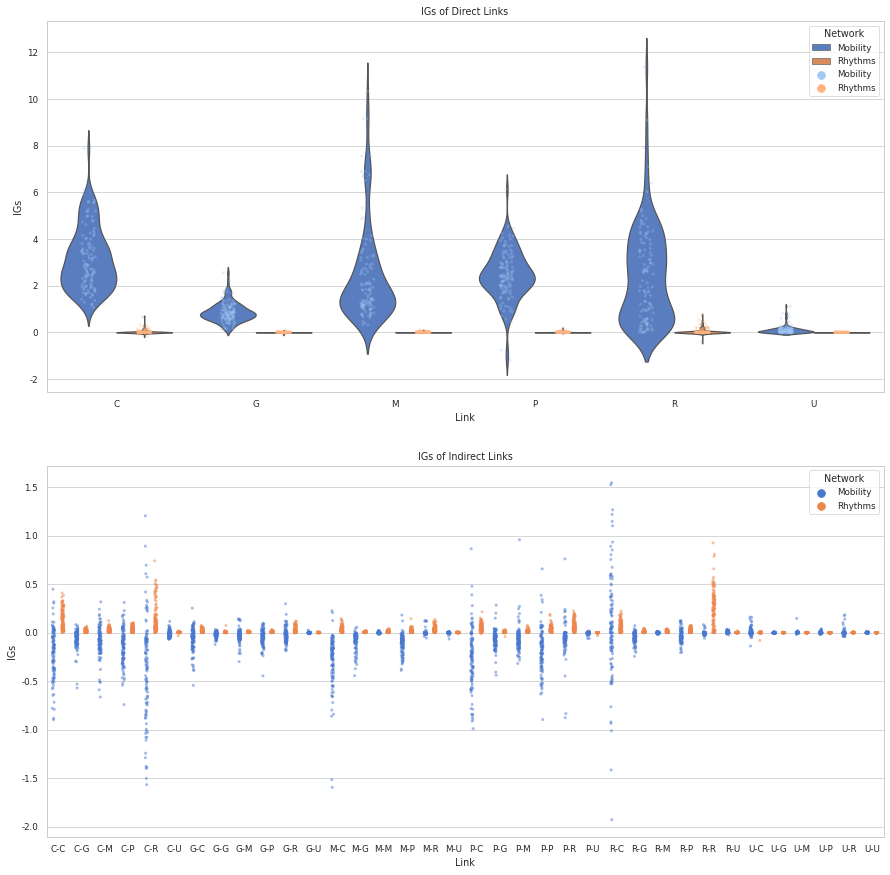

In [86]:
c = 1
sns.set_style('whitegrid')
f, ax = plt.subplots(2, 1, figsize=(15, 15))
display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([direct_link_igs[c_true_idx[c], c, i, :].flatten() for i in range(2)]).astype(float), Link=list(classes) * (2 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(classes) * len(c_true_idx[c])) for i in networks])))
# ax = sns.boxplot(data=display_link_igs, y='VALUE', x='LINK', hue='NETWORK', dodge=True, width=.5)
sns.violinplot(data=display_link_igs, y='IGs', x='Link', hue='Network', scale='width', inner=None, palette=sns.color_palette('muted', 2), bw=.3, ax=ax[0])
sns.stripplot(data=display_link_igs, y='IGs', x='Link', hue='Network', dodge=True, jitter=True, size=3, alpha=.3, palette=sns.color_palette('pastel', 2), ax=ax[0])
display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([indirect_link_igs[c_true_idx[c], c, :, i].flatten() for i in range(2)]), Link=list(link_classes) * (2 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(link_classes) * len(c_true_idx[c])) for i in networks])))
sns.stripplot(data=display_link_igs, y='IGs', x='Link', hue='Network', dodge=True, jitter=True, alpha=.5, size=3, ax=ax[1], palette=sns.color_palette('muted', 2))
# display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([link_igs[c_true_idx[c], c, :, i].mean(0) for i in range(3)]), Link=list(link_classes) * (3 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(link_classes) * len(c_true_idx[c])) for i in ['Interaction', 'Spatial', 'Time']])))
# ax = sns.barplot(data=display_link_igs, y='IGs', x='Link', hue='Network')
ax[0].set_title('IGs of Direct Links')
ax[1].set_title('IGs of Indirect Links')

Text(0.5, 1.0, 'IGs of Indirect Links')

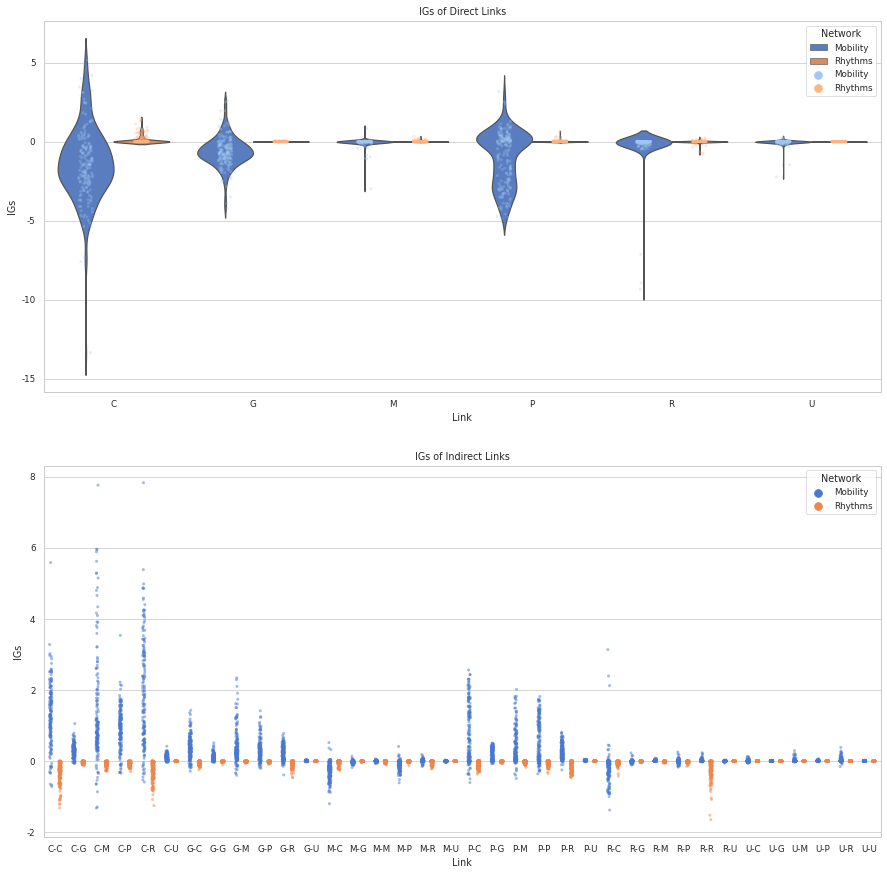

In [87]:
c = 2
sns.set_style('whitegrid')
f, ax = plt.subplots(2, 1, figsize=(15, 15))
display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([direct_link_igs[c_true_idx[c], c, i, :].flatten() for i in range(2)]).astype(float), Link=list(classes) * (2 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(classes) * len(c_true_idx[c])) for i in networks])))
# ax = sns.boxplot(data=display_link_igs, y='VALUE', x='LINK', hue='NETWORK', dodge=True, width=.5)
sns.violinplot(data=display_link_igs, y='IGs', x='Link', hue='Network', scale='width', inner=None, palette=sns.color_palette('muted', 2), bw=.3, ax=ax[0])
sns.stripplot(data=display_link_igs, y='IGs', x='Link', hue='Network', dodge=True, jitter=True, size=3, alpha=.3, palette=sns.color_palette('pastel', 2), ax=ax[0])
display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([indirect_link_igs[c_true_idx[c], c, :, i].flatten() for i in range(2)]), Link=list(link_classes) * (2 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(link_classes) * len(c_true_idx[c])) for i in networks])))
sns.stripplot(data=display_link_igs, y='IGs', x='Link', hue='Network', dodge=True, jitter=True, alpha=.5, size=3, ax=ax[1], palette=sns.color_palette('muted', 2))
# display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([link_igs[c_true_idx[c], c, :, i].mean(0) for i in range(3)]), Link=list(link_classes) * (3 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(link_classes) * len(c_true_idx[c])) for i in ['Interaction', 'Spatial', 'Time']])))
# ax = sns.barplot(data=display_link_igs, y='IGs', x='Link', hue='Network')
ax[0].set_title('IGs of Direct Links')
ax[1].set_title('IGs of Indirect Links')

Text(0.5, 1.0, 'IGs of Indirect Links')

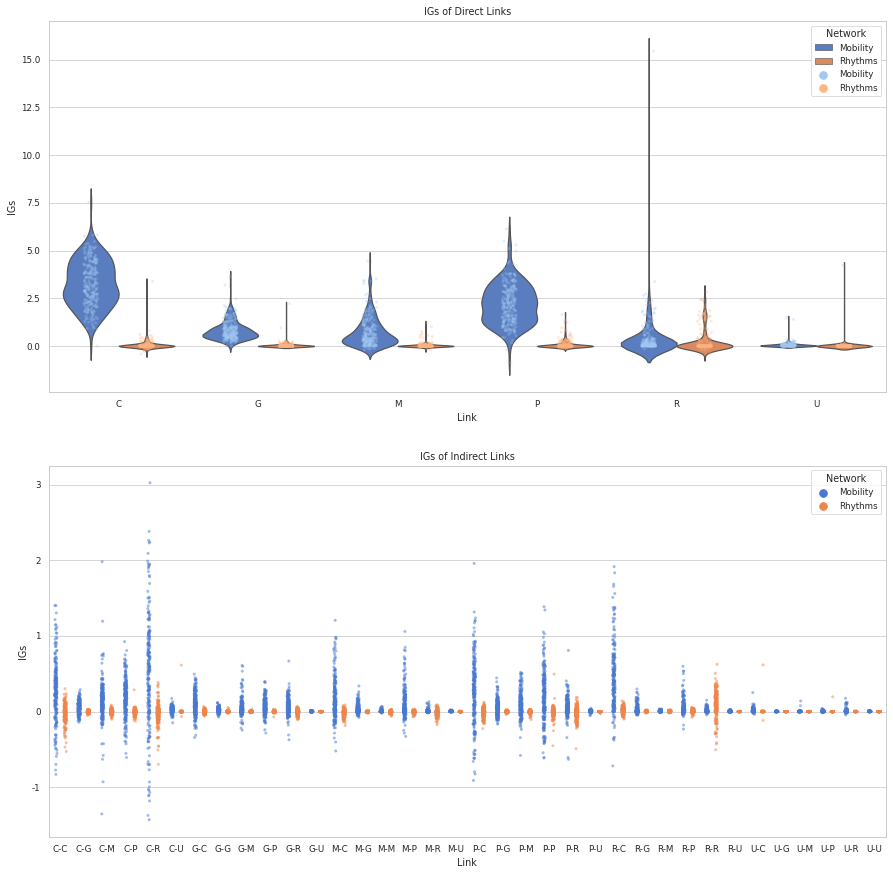

In [88]:
c = 3
sns.set_style('whitegrid')
f, ax = plt.subplots(2, 1, figsize=(15, 15))
display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([direct_link_igs[c_true_idx[c], c, i, :].flatten() for i in range(2)]).astype(float), Link=list(classes) * (2 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(classes) * len(c_true_idx[c])) for i in networks])))
# ax = sns.boxplot(data=display_link_igs, y='VALUE', x='LINK', hue='NETWORK', dodge=True, width=.5)
sns.violinplot(data=display_link_igs, y='IGs', x='Link', hue='Network', scale='width', inner=None, palette=sns.color_palette('muted', 2), bw=.3, ax=ax[0])
sns.stripplot(data=display_link_igs, y='IGs', x='Link', hue='Network', dodge=True, jitter=True, size=3, alpha=.3, palette=sns.color_palette('pastel', 2), ax=ax[0])
display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([indirect_link_igs[c_true_idx[c], c, :, i].flatten() for i in range(2)]), Link=list(link_classes) * (2 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(link_classes) * len(c_true_idx[c])) for i in networks])))
sns.stripplot(data=display_link_igs, y='IGs', x='Link', hue='Network', dodge=True, jitter=True, alpha=.5, size=3, ax=ax[1], palette=sns.color_palette('muted', 2))
# display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([link_igs[c_true_idx[c], c, :, i].mean(0) for i in range(3)]), Link=list(link_classes) * (3 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(link_classes) * len(c_true_idx[c])) for i in ['Interaction', 'Spatial', 'Time']])))
# ax = sns.barplot(data=display_link_igs, y='IGs', x='Link', hue='Network')
ax[0].set_title('IGs of Direct Links')
ax[1].set_title('IGs of Indirect Links')

Text(0.5, 1.0, 'IGs of Indirect Links')

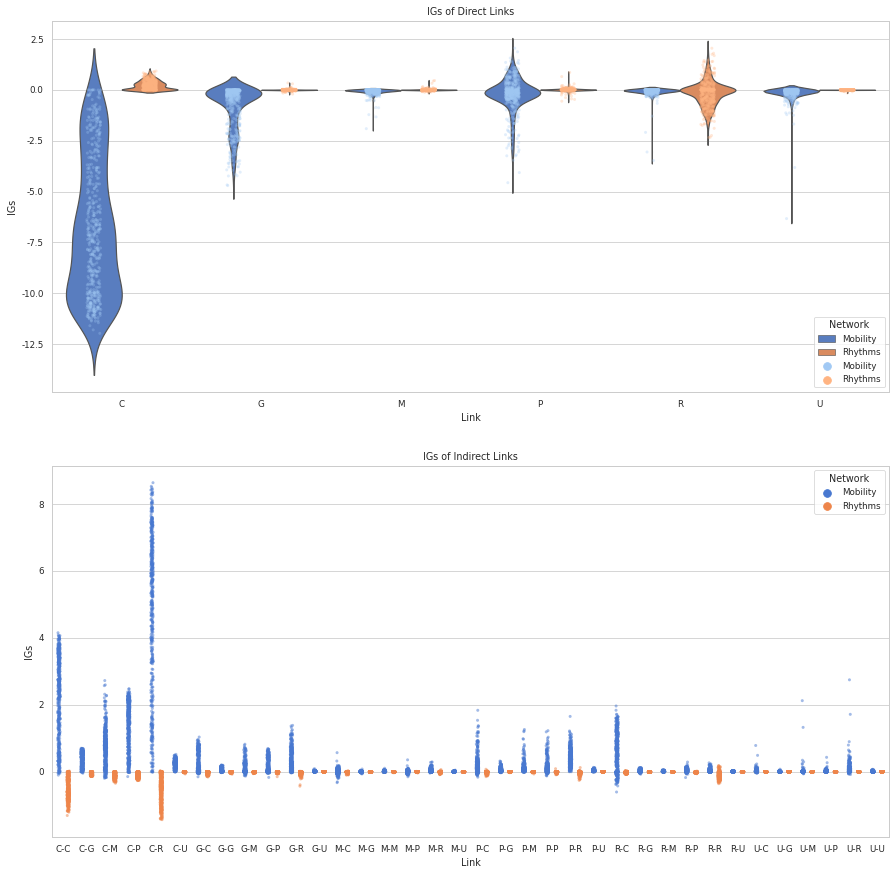

In [89]:
c = 4
sns.set_style('whitegrid')
f, ax = plt.subplots(2, 1, figsize=(15, 15))
display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([direct_link_igs[c_true_idx[c], c, i, :].flatten() for i in range(2)]).astype(float), Link=list(classes) * (2 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(classes) * len(c_true_idx[c])) for i in networks])))
# ax = sns.boxplot(data=display_link_igs, y='VALUE', x='LINK', hue='NETWORK', dodge=True, width=.5)
sns.violinplot(data=display_link_igs, y='IGs', x='Link', hue='Network', scale='width', inner=None, palette=sns.color_palette('muted', 2), bw=.3, ax=ax[0])
sns.stripplot(data=display_link_igs, y='IGs', x='Link', hue='Network', dodge=True, jitter=True, size=3, alpha=.3, palette=sns.color_palette('pastel', 2), ax=ax[0])
display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([indirect_link_igs[c_true_idx[c], c, :, i].flatten() for i in range(2)]), Link=list(link_classes) * (2 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(link_classes) * len(c_true_idx[c])) for i in networks])))
sns.stripplot(data=display_link_igs, y='IGs', x='Link', hue='Network', dodge=True, jitter=True, alpha=.5, size=3, ax=ax[1], palette=sns.color_palette('muted', 2))
# display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([link_igs[c_true_idx[c], c, :, i].mean(0) for i in range(3)]), Link=list(link_classes) * (3 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(link_classes) * len(c_true_idx[c])) for i in ['Interaction', 'Spatial', 'Time']])))
# ax = sns.barplot(data=display_link_igs, y='IGs', x='Link', hue='Network')
ax[0].set_title('IGs of Direct Links')
ax[1].set_title('IGs of Indirect Links')

Text(0.5, 1.0, 'IGs of Indirect Links')

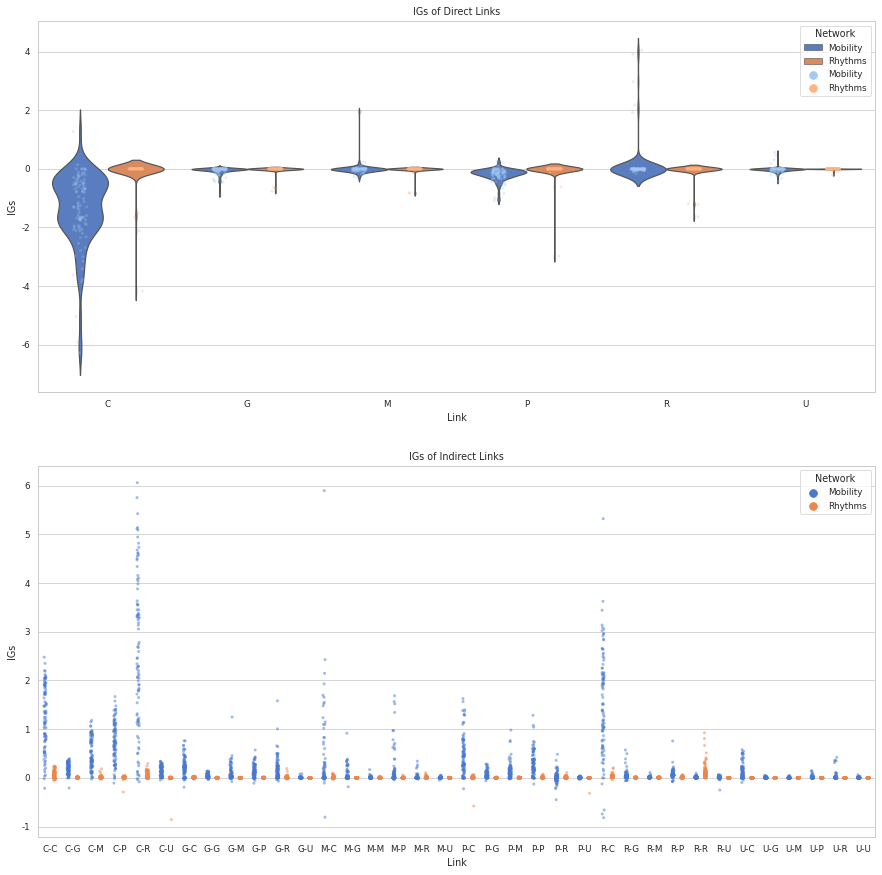

In [90]:
c = 5
sns.set_style('whitegrid')
f, ax = plt.subplots(2, 1, figsize=(15, 15))
display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([direct_link_igs[c_true_idx[c], c, i, :].flatten() for i in range(2)]).astype(float), Link=list(classes) * (2 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(classes) * len(c_true_idx[c])) for i in networks])))
# ax = sns.boxplot(data=display_link_igs, y='VALUE', x='LINK', hue='NETWORK', dodge=True, width=.5)
sns.violinplot(data=display_link_igs, y='IGs', x='Link', hue='Network', scale='width', inner=None, palette=sns.color_palette('muted', 2), bw=.3, ax=ax[0])
sns.stripplot(data=display_link_igs, y='IGs', x='Link', hue='Network', dodge=True, jitter=True, size=3, alpha=.3, palette=sns.color_palette('pastel', 2), ax=ax[0])
display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([indirect_link_igs[c_true_idx[c], c, :, i].flatten() for i in range(2)]), Link=list(link_classes) * (2 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(link_classes) * len(c_true_idx[c])) for i in networks])))
sns.stripplot(data=display_link_igs, y='IGs', x='Link', hue='Network', dodge=True, jitter=True, alpha=.5, size=3, ax=ax[1], palette=sns.color_palette('muted', 2))
# display_link_igs = pd.DataFrame(dict(IGs=np.concatenate([link_igs[c_true_idx[c], c, :, i].mean(0) for i in range(3)]), Link=list(link_classes) * (3 * len(c_true_idx[c])), Network=np.concatenate([[i] * (len(link_classes) * len(c_true_idx[c])) for i in ['Interaction', 'Spatial', 'Time']])))
# ax = sns.barplot(data=display_link_igs, y='IGs', x='Link', hue='Network')
ax[0].set_title('IGs of Direct Links')
ax[1].set_title('IGs of Indirect Links')